# **Projet de Natural Language Processing - 3A ENSAE**

**Inès Deguy, Jeremy Marck**



# Instructions



1.   Vous devez encadrer vous-même votre projet.
Définissez le contexte de votre projet.
Encadrez et notez une ou plusieurs questions clés auxquelles vous tenterez de répondre grâce aux données choisies.
Définissez et expliquez un protocole d'expérimentation clair pour répondre à ces questions (quelles techniques vous utiliserez, sur la base de quelles tâches, quels modèles, quel prétraitement, quel entrainement du modèle, quelle évaluation vous avez l'intention de faire). 

2.   Choix d'une base de données.

3.   Vous devez utiliser au minimum une des techniques de 'Word Embedding' suivantes : 
Skip-gram word2vec, Fastext (bag-of-n-grams), Glove, ELMo, BERT (Roberta, CamemBERT, …) 

4.   Vous devez construire un modèle spécifique à la tâche pour effectuer l'un des trois types de tâches parmi : Étiquetage des séquences, classification des séquences, génération de séquences (par exemple, étiquetage au point de vente, NER, analyse des sentiments, détection des intentions, traduction, AQ...). 

1.   Vous devez évaluer votre modèle à l'aide d'une analyse qualitative et d'une analyse quantitative
2.   Présentez vos expériences et vos résultats de manière synthétique. Dessinez les futurs travaux intéressants à faire suite à votre projet 





In [0]:
pip install plot_metric

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plot_metric.functions import BinaryClassification
from sklearn.model_selection import GridSearchCV
from functools import reduce
from operator import add
from tqdm import tqdm
import nltk
import gc
import os, glob
import spacy
from wordcloud import WordCloud
from spacy.matcher import PhraseMatcher, Matcher
from spacy.tokens import Token, Doc
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from scipy.stats import ttest_ind, sem
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
import seaborn as sns
import re
from functools import reduce
from operator import concat
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
class style:
   BOLD = '\033[1m'
   END = '\033[0m'

# Plan

This work is dedicated to the study of the New York Times databases available on Kaggle. These databses are composed of comments and articles, including several variables of interest. This is a prospective work as our objectives are to make some data exploration, to build some predictive models in order to predict interesting variables and perform a sentiment analysis. 

Because of RAM available through Google Colab, we will restrict our study to a selected month (April 2017). 

Regarding data exploration, the objective is to discover which variables compose the datasets and get the feeling of what can be predicted. This also concerns identifying which preprocessing needs to be realized so as to apply standard NLP methods, such as Tokenization and word embedding.

Regarding predictions, we will try to predict whether a new comment receives at least one upvote or not. This will be our first study and we made to present all the methods used for performing this analysis. Some models perform good predictive results. We will also try to predict whether a comment is chosen to be promoted by the NYT direction or not. This is our second study. 

Sentiment analysis will also be realized using a sentiment score available through NLTK. This is mainly data exploration, identifying which themes produce the best and the worst sentiment scores, identifying sentiment scores with respect to comments and articles. This is the third part of our study. 


# Data preprocessing: importation, exploration, cleaning and tokenization

## Data importation

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=18PXRu8iO4uQP2-_xBqSGzxpRduUGgfNg'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
com_ap_17 = pd.read_csv('Filename.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (25,26) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
link = 'https://drive.google.com/open?id=1FOW8hxvrGh6vHizLTle0l7WbwhAQnEdM'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv')  
art_ap_17 = pd.read_csv('Filename.csv')

**Choosing a database**

We choose to conduct our study using the comment and article databases for April 2017 due to a computational problem related to the RAM available through Google Colab. 
The choice of April 2017 is arbitrary.

Dimension of the comments database

In [0]:
data_c = com_ap_17
data_comments = data_c['commentBody'][0:10000] # Texte part of the database.
print('Number of observations: ',data_c.shape[0])
print('Number of variables:',data_c.shape[1])

Number of observations:  243832
Number of variables: 34


Dimension of the articles database

In [0]:
data_a = art_ap_17
data_article = data_a['snippet'] # Text part of the database. 
print('Number of observations: ',data_a.shape[0])
print('Number of variables:', data_a.shape[1])

Number of observations:  886
Number of variables: 16


**Remark:** the two databases can be merged using the "ArticleID" variable. There are fewer observations in the articles database because there is much more than one observation per article!

## Data exploration

We perform some data exploration for both the comment database and the articles one. This exploration is performed by using the following function, editing some descriptive statistics to get an understanding of the databases.

In [0]:
def stats(data,is_com):
  # General informations.
  print(style.BOLD + '** Informations about the database' + style.END)
  print(style.BOLD + 'Number of observations, columns:' + style.END, data.shape)
  print(style.BOLD + 'Columns:' + style.END,data.columns)
  print('------------')
  if is_com:
    # Identification of some statistics of characters per comment.
    l = []
    print(style.BOLD + '** Some statistics of characters per comment' + style.END)
    for i in range(len(data)):
      l.append(len(data.commentBody[i]))
    print(style.BOLD + 'Average number of characters per comment:' + style.END, round(np.mean(l),0))
    print(style.BOLD + 'Standard deviation of characters per comment:' + style.END, round(np.std(l),0))
    print(style.BOLD + 'Minimal number of characters per comment:' + style.END, min(l))
    print(style.BOLD + 'Maximal number of characters per comment:' + style.END, max(l))
    print(style.BOLD + '25% quantile of characters per comment:' + style.END, np.quantile(l,0.25))
    print(style.BOLD + '50% quantile (Mode) of characters per comment:' + style.END, np.quantile(l,0.5))
    print(style.BOLD + '75% of characters per comment:' + style.END, np.quantile(l,0.75))
    # Plot
    plt.hist(l, bins = 25)
    plt.title('Distribution of the number of characters')
    plt.xlabel('Number of characters')
    plt.ylabel('Occurences')
    plt.grid(True)
    plt.show()
  else:  
    # Identification of some statistics of characters per article.
    l = []
    print(style.BOLD + '** Some statistics about the number of characters per article:' + style.END)
    for i in range(len(data)):
      l.append(len(data.snippet[i]))
    print(style.BOLD + 'Average number of characters per article:' + style.END, round(np.mean(l),0))
    print(style.BOLD + 'Standard deviation of characters per article:' + style.END, round(np.std(l),0))
    print(style.BOLD + 'Minimal number of characters per article:' + style.END, min(l))
    print(style.BOLD + 'Maximal number of characters per article:' + style.END, max(l))
    print(style.BOLD + '25% quantile of characters per article:' + style.END, np.quantile(l,0.25))
    print(style.BOLD + '50% quantile (Mode) of characters per article:' + style.END, np.quantile(l,0.5))
    print(style.BOLD + '75% of characters per article:' + style.END, np.quantile(l,0.75))
    plt.hist(l, bins = 25)
    plt.title('Distribution of the number of characters')
    plt.xlabel('Number of characters')
    plt.ylabel('Occurences')
    plt.grid(True)
    plt.show()
    print('--------')

### Comment database

This section provides general informations related to the database as well as brief descriptive statistics.

Results are obtained using the 'stats' function edited above.

Quick overview of the database.

In [0]:
data_c.head()

,approveDate,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,editorsSelection,parentID,parentUserDisplayName,permID,picURL,recommendations,recommendedFlag,replyCount,reportAbuseFlag,sharing,status,timespeople,trusted,updateDate,userDisplayName,userID,userLocation,userTitle,userURL,inReplyTo,articleID,sectionName,newDesk,articleWordCount,printPage,typeOfMaterial
0,1491245186,This project makes me happy to be a 30+ year T...,22022598.0,22022598,<br/>,comment,1.491237e+09,1,False,0.0,NaN,22022598,https://graphics8.nytimes.com/images/apps/time...,2.0,NaN,0.0,NaN,0,approved,1.0,0.0,1491245186,Rob Gayle,46006296,"Riverside, CA",NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News
1,1491188619,Stunning photos and reportage. Infuriating tha...,22017350.0,22017350,NaN,comment,1.491180e+09,1,False,0.0,NaN,22017350,https://graphics8.nytimes.com/images/apps/time...,1.0,NaN,0.0,NaN,0,approved,1.0,0.0,1491188619,Susan A.,29202761,<br/>,NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News
2,1491188617,Brilliant work from conception to execution. I...,22017334.0,22017334,<br/>,comment,1.491179e+09,1,False,0.0,NaN,22017334,https://graphics8.nytimes.com/images/apps/time...,3.0,NaN,0.0,NaN,0,approved,1.0,0.0,1491188617,Meta,63944806,Raleigh NC,NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News
3,1491167820,NYT reporters should provide a contributor's l...,22015913.0,22015913,<br/>,comment,1.491150e+09,1,False,0.0,NaN,22015913,https://graphics8.nytimes.com/images/apps/time...,7.0,NaN,2.0,NaN,0,approved,1.0,0.0,1491167820,Tom Wyrick,1266184,"Missouri, USA",NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News
4,1491167815,Could only have been done in print. Stunning.,22015466.0,22015466,<br/>,comment,1.491147e+09,1,False,0.0,NaN,22015466,http://profile.ak.fbcdn.net/hprofile-ak-snc4/h...,5.0,NaN,0.0,NaN,0,approved,1.0,0.0,1491167815,Joe Sharkey,61121360,"Tucson, Arizona",NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News


Let us now use the function to perform data exploration for the comment database.

** Informations about the database
Number of observations, columns: (243832, 34)
Columns: Index(['approveDate', 'commentBody', 'commentID', 'commentSequence',
       'commentTitle', 'commentType', 'createDate', 'depth',
       'editorsSelection', 'parentID', 'parentUserDisplayName', 'permID',
       'picURL', 'recommendations', 'recommendedFlag', 'replyCount',
       'reportAbuseFlag', 'sharing', 'status', 'timespeople', 'trusted',
       'updateDate', 'userDisplayName', 'userID', 'userLocation', 'userTitle',
       'userURL', 'inReplyTo', 'articleID', 'sectionName', 'newDesk',
       'articleWordCount', 'printPage', 'typeOfMaterial'],
      dtype='object')
------------
** Some statistics of characters per comment
Average number of characters per comment: 431.0
Standard deviation of characters per comment: 379.0
Minimal number of characters per comment: 1
Maximal number of characters per comment: 1998
25% quantile of characters per comment: 145.0
50% quantile (Mode) of characters per c

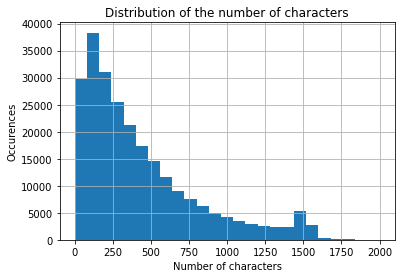

In [0]:
stats(data_c,True)

**Remarks:** the distribution of the number of characters per comment seems to be approachable by an exponential distribution. With a few exceptions:



1.   The beginning of the distribution which first goes through an increasing phase before starting the decreasing phase. 
2.   The peak at the end of the distribution.



### Article database

Quick overview of the database

In [0]:
data_a.head()

,abstract,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,NaN,58def1347c459f24986d7c80,716,By STEPHEN HILTNER and SUSAN LEHMAN,article,Finding an Expansive View of a Forgotten Peop...,"['Photography', 'New York Times', 'Niger', 'Fe...",3,Insider,2,2017-04-01 00:15:41,Unknown,One of the largest photo displays in Times his...,The New York Times,News,https://www.nytimes.com/2017/03/31/insider/nig...
1,NaN,58def3237c459f24986d7c84,823,By GAIL COLLINS,article,"And Now, the Dreaded Trump Curse","['United States Politics and Government', 'Tru...",3,OpEd,23,2017-04-01 00:23:58,Unknown,Meet the gang from under the bus.,The New York Times,Op-Ed,https://www.nytimes.com/2017/03/31/opinion/and...
2,NaN,58def9f57c459f24986d7c90,575,By THE EDITORIAL BOARD,article,Venezuela’s Descent Into Dictatorship,"['Venezuela', 'Politics and Government', 'Madu...",3,Editorial,22,2017-04-01 00:53:06,Unknown,A court ruling annulling the legislature’s aut...,The New York Times,Editorial,https://www.nytimes.com/2017/03/31/opinion/ven...
3,NaN,58defd317c459f24986d7c95,1374,By MICHAEL POWELL,article,Stain Permeates Basketball Blue Blood,"['Basketball (College)', 'University of North ...",3,Sports,1,2017-04-01 01:06:52,College Basketball,"For two decades, until 2013, North Carolina en...",The New York Times,News,https://www.nytimes.com/2017/03/31/sports/ncaa...
4,NaN,58df09b77c459f24986d7ca7,708,By DEB AMLEN,article,Taking Things for Granted,['Crossword Puzzles'],3,Games,0,2017-04-01 02:00:14,Unknown,In which Howard Barkin and Will Shortz teach u...,The New York Times,News,https://www.nytimes.com/2017/03/31/crosswords/...


Let us now perform some data exploration for the articles database.

** Informations about the database
Number of observations, columns: (886, 16)
Columns: Index(['abstract', 'articleID', 'articleWordCount', 'byline', 'documentType',
       'headline', 'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')
------------
** Some statistics about the number of characters per article:
Average number of characters per article: 114.0
Standard deviation of characters per article: 39.0
Minimal number of characters per article: 22
Maximal number of characters per article: 250
25% quantile of characters per article: 88.0
50% quantile (Mode) of characters per article: 115.0
75% of characters per article: 145.75


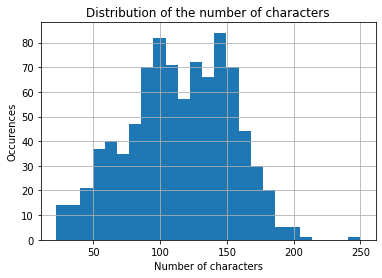

--------


In [0]:
stats(data_a,False)

**Note**: there are fewer observations for the articles database than for the comments database. These two databases are linked and each article has an average number of comments greater than 1, hence the difference.

# Data cleaning, tokenization and preprocessing

Some NLP techniques, developed through this study, are based on word embedding (which is the action to transform words in vector). A good word embedding needs some data 'cleaning' by droping uppercases and characters not present in the alphabet, for instance. This is because word embedding analyzes the word in a 'context': thus, these types of undesirable characters could modify the context and thus the process of word embedding.

## Cleaning function 

The cleaning function is used to 'normalize' the text which will be used as a feature for predictive models. This is a fundamental step because word embedding (by several methods available in this project) depends on a good cleaning. By cleaning, we mean applying lower(), dropping HTLM pieces of code, mathematical elements, '#' etc ...

**Remark:** some exploration of the database is needed to identify the appropriate cleaning to compute NLP models.

Printing some comments:

In [0]:
for i in range(11):
  print(i, data_comments.iloc[i])

0 This project makes me happy to be a 30+ year Times subscriber... continue to innovate across all platforms, please.
1 Stunning photos and reportage. Infuriating that the Trump admistration's draconian reinstatement of the global gag order will prevent men and women from receiving appropriate family planning advice, so obviously desperately   needed.
2 Brilliant work from conception to execution. I've never seen anything like it.  As a paper of record it is important to leave a record of these and other peoples for whom no one else speaks.  Please keep humanizing what are otherwise bland statistics.  It matters. Time and again their stories sounded like mine, could have been mine.  We're about to see hordes of people far away experiencing utter devastation.  Empathy goes away unless there are names and stories, and pictures.  Links to helping at organizations, resources....  
3 NYT reporters should provide a contributor's link to a crowdfunding project or aid organization focused on t

**Remark**: comments need a specific cleaning to remove URL, html tag, hashtag, etc... (look at the 10th one for instance).

Printing some articles:

In [0]:
for i in range(11):
  print(i,data_article.iloc[i])

0 One of the largest photo displays in Times history, of people who have fled Boko Haram, required an effort just as immense.
1 Meet the gang from under the bus.
2 A court ruling annulling the legislature’s authority represents a dangerous turning point for Venezuela.
3 For two decades, until 2013, North Carolina engaged in academic improprieties that benefited its student-athletes. The repercussions are still being felt.
4 In which Howard Barkin and Will Shortz teach us a lesson.
5 In this visually ravishing production, Bobby Cannavale steps into a part that has been waiting for him for decades.
6 For the author, this gleaming, complex city in British Columbia is “a rolling, improvisatory work in progress.”
7 About $13 million has been paid out over the years to address complaints from women about Mr. O’Reilly’s behavior. He denies the claims have merit.
8 Getting rid of mice isn’t easy, but it’s a co-op board’s responsibility if a building becomes infested.
9 A proposed “border adjus

**Remark:** article's snippets do not need specific cleaning.

Importing TweetTokenizer (a very famous tokenizer).

In [0]:
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**Building the cleaning function**

If the data is an article the function only lowers each phrases.

In [0]:
def cleaning_function(phrase, is_comment=True):
  if is_comment:
    phrase = list(filter(lambda x: "http" not in x, phrase))
    phrase = list(filter(lambda x: "hre" not in x, phrase))
    phrase = list(filter(lambda x: "www" not in x, phrase))
    phrase = list(filter(lambda x: x[0]+x[-1] != '<>', phrase))
    phrase = list(filter(lambda x: "<" not in x, phrase))
    phrase = list(filter(lambda x: ">" not in x, phrase))
    phrase = list(filter(lambda x: '"' not in x, phrase))
    phrase = list(filter(lambda x: "=" not in x, phrase))
    phrase = list(filter(lambda x: "_blank" not in x, phrase))
    phrase = list(map(lambda x: x.replace('#', ''), phrase))
  phrase = list(map(lambda x: x.lower(), phrase))
  return phrase

**Reminder : what is a token ?** Tokenization is the act of breaking up a sequence of strings into pieces such as words, keywords, phrases, symbols and other elements called tokens.


The following piece of code provides an instance of what a preloaded tokenizer does (the so-called TweetTokenizer).

In [0]:
a = data_comments.iloc[7]
print(style.BOLD + '---- Before Tokenization ----' + style.END)
print(a)
print(style.BOLD + '---- After Tokenization ----' + style.END)
a1 = TweetTokenizer().tokenize(data_comments.iloc[7])
print(a1)

---- Before Tokenization ----
The OASIS Initiative, which I started with Prof. Malcolm Potts at UC Berkeley is focusing on building local leadership and the evidence base necessary to help people in the Sahel face Africa's greatest development challenge: unprecedented population growth and effects of climate change in an already fragile region. Please consider supporting our work - the "donate" button is on the top right. Gifts to UC Berkeley have only about 3% indirect cost rate. <a href="http://www.oasisinitiative.berkeley.edu" title="www.oasisinitiative.berkeley.edu" target="_blank">www.oasisinitiative.berkeley.edu</a> 
---- After Tokenization ----
['The', 'OASIS', 'Initiative', ',', 'which', 'I', 'started', 'with', 'Prof', '.', 'Malcolm', 'Potts', 'at', 'UC', 'Berkeley', 'is', 'focusing', 'on', 'building', 'local', 'leadership', 'and', 'the', 'evidence', 'base', 'necessary', 'to', 'help', 'people', 'in', 'the', 'Sahel', 'face', "Africa's", 'greatest', 'development', 'challenge', ':

**Comparison of the tokens before and after the cleaning function.**

The following piece of code provides a comparison of tokens before/after cleaning.

In [0]:
# Tokenization part using Tweet Tokenizer.
a1 = TweetTokenizer().tokenize(data_comments.iloc[7])
a2 = cleaning_function(TweetTokenizer().tokenize(data_comments.iloc[7]))

# Before cleaning.
print(style.BOLD + '---- Before Cleaning ----' + style.END)
l = []
for elem in a1:
  l.append(elem)
s = ' '.join(l)
print(s)
print('------------')

# After cleaning.
print(style.BOLD + '---- After Cleaning ----' + style.END)
l = []
for elem in a2:
  l.append(elem)
s = ' '.join(l)
print(s)

---- Before Cleaning ----
The OASIS Initiative , which I started with Prof . Malcolm Potts at UC Berkeley is focusing on building local leadership and the evidence base necessary to help people in the Sahel face Africa's greatest development challenge : unprecedented population growth and effects of climate change in an already fragile region . Please consider supporting our work - the " donate " button is on the top right . Gifts to UC Berkeley have only about 3 % indirect cost rate . < a href = " http://www.oasisinitiative.berkeley.edu " title = " www.oasisinitiative.berkeley.edu " target = " _blank " > www.oasisinitiative.berkeley.edu </a>
------------
---- After Cleaning ----
the oasis initiative , which i started with prof . malcolm potts at uc berkeley is focusing on building local leadership and the evidence base necessary to help people in the sahel face africa's greatest development challenge : unprecedented population growth and effects of climate change in an already fragile

## Tokenization functions

**This section provides different Tokenizers.** These are very popular ones from:


1.   NLTK library.
2.   Spacy library.
3.   Gensim library.

The user can use the most efficient function.



**Using NLTK/TweetTokenizer**

In [0]:
import nltk
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

def tokenization_nltk(corpus):
  tokenizer = TweetTokenizer()
  tokenized = []

  for ele in tqdm(corpus):
    tokens = tokenizer.tokenize(ele)
    tokens = cleaning_function(tokens)
    tokenized.append(tokens)

  return tokenized  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
# Tokenizing the comments database.

c_tokenization_nltk = tokenization_nltk(data_comments)

print("Number of tokens for the comments using nltk is : {0}" \
      .format(len(reduce(add, tokenization_nltk(data_comments[0:1000])))))

100%|██████████| 1000/1000 [00:00<00:00, 3044.30it/s]

Number of tokens for the comments using nltk is : 70067


In [0]:
# Tokenizing the articles database.

a_tokenization_nltk = tokenization_nltk(data_article)

print("Number of tokens for the article using nltk is : {0}" \
      .format(len(reduce(add, a_tokenization_nltk))))

100%|██████████| 886/886 [00:00<00:00, 7867.32it/s]

Number of tokens for the article using nltk is : 19579


**Using Spacy.**

In [0]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

def tokenization_spacy(corpus):
  tokenizer = Tokenizer(English().vocab)
  tokenized=[]
  tokenized=corpus.apply(lambda x: [w.text for w in tokenizer(x)]).array
  return tokenized


In [0]:
# Tokenizing the comments database.

c_tokenization_spacy = tokenization_spacy(data_comments[0:1000])

print("Number of tokens for the comments using spacy is : {0}" \
      .format(len(reduce(add,c_tokenization_spacy))))

Number of tokens for the comments using spacy is : 62310


In [0]:
# Tokenizing using the articles database.

a_tokenization_spacy = tokenization_spacy(data_article)

print("Number of tokens for the article using spacy is : {0}" \
      .format(len(reduce(add,a_tokenization_spacy))))

Number of tokens for the article using spacy is : 16828


**Using Gensim.**

In [0]:
from gensim.models.phrases import Phrases, Phraser

def phrases_expression(tokenized,threshold=50):
  phraser_= []
  phrases = Phrases(tokenized,threshold=threshold)
  phraser = Phraser(phrases)

  for ele in tokenized:
    phraser_.append(phraser[ele])
  return phraser_

In [0]:
phrases_c_nltk = phrases_expression(c_tokenization_nltk[0:1000])
print("Number of tokens for the comments using nltk and phrases is : {0}" \
      .format(len(reduce(add,phrases_c_nltk))))

Number of tokens for the comments using nltk and phrases is : 69225


In [0]:
phrases_c_spacy = phrases_expression(c_tokenization_spacy[0:1000])
print("Number of tokens for the comments using spacy and phrases is : {0}" \
      .format(len(reduce(add,phrases_c_spacy))))

Number of tokens for the comments using spacy and phrases is : 61825


In [0]:
phrases_a_nltk = phrases_expression(a_tokenization_nltk)
print("Number of tokens for the article using nltk and phrases is : {0}" \
      .format(len(reduce(add,phrases_a_nltk))))

Number of tokens for the article using nltk and phrases is : 19213


In [0]:
phrases_a_spacy = phrases_expression(a_tokenization_spacy)
print("Number of tokens for the article using spacy and phrases is : {0}" \
      .format(len(reduce(add,phrases_a_spacy))))

Number of tokens for the article using spacy and phrases is : 16760


**Another Tokenization function**

In [0]:
# Usage of Phrases and Phraser from gensim
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

#On fait des fonctions pour pouvoir enlever hashtags url html 
def remove_hashtags(tokens):
  tokens = map(lambda x: x.replace('#', ''), tokens)
  return list(tokens)

def remove_url(tokens):
  tokens = filter(lambda x: "http" not in x, tokens)
  return list(tokens)

def remove_html(tokens):
  tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
  return list(tokens)

from tqdm import tqdm
def tokenization2(corpus):
  ''' modified version for our data structure (flattened and only for tweets proc)'''
  tokenizer = TweetTokenizer() 
  tokenized_sentences = []
  for sample in tqdm(corpus):
    ## we remove sentence split as we need to keep the whole tweet as one
    # # separating sentences
    # for sentence in sent_detector.tokenize(sample):
    tokens = tokenizer.tokenize(sample)
    tokens = remove_url(tokens)
    tokens = remove_html(tokens)
    tokens = remove_hashtags(tokens)
    tokens = list(map(lambda x: x.lower(), tokens))
    tokenized_sentences.append(tokens)
  return tokenized_sentences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Remark:** we will use this tokenization function latter for our analysis.

## Word Embedders

**Count Vectorizer**

It is a Word Embedder available through Sklearn : Convert a collection of text documents to a matrix of token counts.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

def countvect(x_train, x_test):

  cv = CountVectorizer()
  cv.fit(x_train)
  x_train_cv = cv.transform(x_train)
  x_test_cv = cv.transform(x_test)
  return x_train_cv, x_test_cv

**Word2Vec Model**

It is the so-called W2V word embedder.

In [0]:
from gensim.models import Word2Vec
from multiprocessing import cpu_count

def w2v(x_train,x_test):

  cpu = cpu_count()
  x_train_token=tokenization_nltk(x_train)
  pol = Word2Vec(x_train_token, size = 100, window = 5, min_count = 3, workers = cpu)
  pol.train(x_train_token, total_examples = len(x_train), epochs = 10)

  x_train_w = []
  x_test_w = []

  for sample in x_train: 
    v = list()
    for token in sample.split(' '):
      try: v.append(pol.wv.get_vector(token))
      except: v.append(np.zeros(100)) 
    x_train_w.append(np.mean(v, axis = 0))

  for sample in x_test: 
    v = list()
    for token in sample.split(' '):
      try: v.append(pol.wv.get_vector(token))
      except: v.append(np.zeros(100)) 
    x_test_w.append(np.mean(v, axis = 0))

  return x_train_w,x_test_w


# 1.Predicting comments likes (upvotes)

**Aim:** the objective of this section is to predict whether a comment will receive at least one like or not, using the 'recommendations' variable as a target. Through our analyzis, we faced many different problems that we choose to describe right now. 

Our approach consisted in:

1. Editing some statistics regarding the 'Recomendation' variable (our target function).
2. Binarizing this target variable so as to be able to perform some predictive models.
3. Choosing a metrics to evaluate our models. 

Problems faced:

1. Unbalanced classes.
2. Choosing the good predictor.
3. Adding some features in order to improve our performances.

## 1.1. Some statistics about the 'recommendations' variable

The recommendations variable is the target. We need to perform some statistics to understand the distribution of the variable and design a pertinent way to implement a predictive model.

Let us first import the database:

In [0]:
data = com_ap_17

The statistics computed next are the following:

1.   Average recommendations.
2.   Variance of recommendations.
3.   Number of unique elements.
4.   Identification of major quantiles.
5.   Percentage of comments that received 0 recommendations.
6.   Main percentages. 

In [0]:
print('-------- Some statistics for the Recommendation variable: Recommendation per comment --------')
l = []
# Identifying mean and variance.
for elem in data.recommendations:
  l.append(elem)
print(style.BOLD + 'Mean of recommendations:' + style.END, round(np.mean(l),2))
print(style.BOLD + 'Variance of recommendations:' + style.END, round(np.std(l),2))
print(style.BOLD + 'Maximal recommendations:' + style.END, max(l))
l = sorted(l)

# Identifying number of different recommendations
l_unique = []
for elem in l:
  if elem not in l_unique:
    l_unique.append(elem)
print(style.BOLD + 'Number of unique elements:' + style.END, len(l_unique))

# Identifying the median
print(style.BOLD + 'Median of recommendations:' + style.END, np.median(l))
print(style.BOLD + '25% quantile:' + style.END, np.quantile(l, 0.25))
print(style.BOLD + '75% quantile:' + style.END, np.quantile(l,0.75))
print(style.BOLD + '95% quantile:' + style.END, np.quantile(l,0.95))

# Printing some percentages.
l_count = [i for i in range(0,10,4)]
for i in l_count:
  somme = 0
  for elem in l:
    if elem == i:
      somme += 1
  print(style.BOLD + 'Percentage of %s recommendations'%(i) + style.END, round(somme/len(l),2)*100,'%')

-------- Some statistics for the Recommendation variable: Recommendation per comment --------
Mean of recommendations: 17.63
Variance of recommendations: 93.22
Maximal recommendations: 7938.0
Number of unique elements: 1232
Median of recommendations: 3.0
25% quantile: 1.0
75% quantile: 9.0
95% quantile: 53.0
Percentage of 0 recommendations 22.0 %
Percentage of 4 recommendations 6.0 %
Percentage of 8 recommendations 3.0 %


## 1.2. Preprocessing and evaluation function

**Data preprocessing.** It consists of building a binary variable:

1.   If the comment did not receive any like, the value is 0.
2.   Otherwise, the value is 1.

In [0]:
def data_process1(data):
  # Creating a binary variable.
  data['reco_categ2'] = pd.Series([0 for x in range(len(data))])
  for i in range(len(data)):
    if data['recommendations'][i] == 0:
      data['reco_categ2'][i] += 0
    else:
      data['reco_categ2'][i] += 1
  # Some exploration.
  return data

In [0]:
data = com_ap_17
data = data_process1(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Evaluation function.** The function returns main metrics for a classification problem:

1. Accuracy.
2. F1 Score.
3. Recall.
4. Precision.

In [0]:
def evaluation(y_test_list,y_test_pred_list):
  # Accuracy
  somme = 0
  for i in range(len(y_test_list)):
    if y_test_list[i] == y_test_pred_list[i]:
      somme += 1
  print(style.BOLD + 'Accuracy:' + style.END, round(somme/len(y_test_list),2))

  # F1 Score
  from sklearn.metrics import f1_score
  a = f1_score(y_test_list, y_test_pred_list, average='macro')
  print(style.BOLD + 'F1 Score:' + style.END, round(a,2))

  # Recall
  from sklearn.metrics import recall_score
  b = recall_score(y_test_list, y_test_pred_list, average='macro')
  print(style.BOLD + 'Recall:' + style.END, round(b,2))

  # Precision
  from sklearn.metrics import precision_score
  c = precision_score(y_test_list, y_test_pred_list, average='macro')
  print(style.BOLD + 'Precision:' + style.END, round(c,2))

  # return 
  print('--------')
  return round(somme/len(y_test_list),2), round(a,2), round(b,2), round(c,2)

## 1.3. Predicting receiving at least one like focusing on accuracy

In this section, we try to predict whether a comment receives at least one like or not. Our optimization is based on maximizing accuracy. This is debatable and subject to evolution, as discussed below. We train three main models: 

1. Random Forest classifier (optimized with GridSearch).
2. Linear classifier.
3. A Keras Neural Network classifier.

### Random Forest Classifier

**Explanation:** in this section, we proceed to the setup of a Random Forest Classifier and the tuning of hyperparameters such as the number of estimators (trees in the forest) and the criterion to be optimized.

**Grid Search hyperparameters optimization.** It consists of testing all the pre-determined combinations of parameters. The procedure returns the best combination. The procedure is performed using Sklearn.

In [0]:
from sklearn.model_selection import GridSearchCV

def grid_search(data,n_obs,test_size):
  # Setting the X and y.
  y = data.reco_categ2[0:n_obs]
  X = data.commentBody[0:n_obs]
  print(y.shape)
  print(X.shape)
  # Tokenization.
  print(style.BOLD + '-------- Tokenization --------' + style.END)
  X = tokenization2(X)
  X = [' '.join(ele) for ele in X]
  # Split train-test.
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  print("La longueur de l'échantillon train est : {0}".format(len(X_train)))
  print("La longueur de l'échantillon de test est : {0}".format(len(X_test)))
  # CountVectorizer.
  from sklearn.feature_extraction.text import CountVectorizer
  # Ca prend les phrases du corpus en ligne, en features tous les mots du corpus.
  # Pour chaque ligne, en fonction de la feature, on a le nombre d'apparition du mot 
  # de la feature.
  #X_train_cv, X_test_cv = w2v(X_train, X_test)
  count_vectorizer = CountVectorizer()
  X_train_cv = count_vectorizer.fit_transform(X_train)
  X_test_cv = count_vectorizer.transform(X_test)
  # Training the model.
  print(style.BOLD + '-------- Training the model --------' + style.END)
  from sklearn.ensemble import RandomForestClassifier
  rfc = RandomForestClassifier(random_state=42)
  rfc.fit(X_train_cv, y_train)
  # Grid Search
  print(style.BOLD + '-------- Runing the Grid Search --------' + style.END)
  param_grid = {'n_estimators': [100,200,300,400,500],'criterion' :['gini', 'entropy']}
  CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3)
  CV_rfc.fit(X_train_cv, y_train)
  print(CV_rfc.best_params_)


In [0]:
## Not to be run once again as GridSearch optimization has already been done.
#grid_search(data,1000,0.25)

**Best parameters:**

1.   n_estimators = 100
2.   criterion = 'gini'



**Computing the Classifier**

A function that takes as input a database, the number of observations mobilized as well as the size of the test sample. 

In [0]:
def random_forest_recommendations(data,n_obs,test_size):
  # Setting the X and y.
  y = data.reco_categ2[0:n_obs]
  X = data.commentBody[0:n_obs]
  print(y.shape)
  print(X.shape)
  # Tokenization.
  print(style.BOLD + '-------- Tokenization --------' + style.END)
  X = tokenization2(X)
  X = [' '.join(ele) for ele in X]
  # Split train-test.
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  print("La longueur de l'échantillon train est : {0}".format(len(X_train)))
  print("La longueur de l'échantillon de test est : {0}".format(len(X_test)))
  # CountVectorizer.
  from sklearn.feature_extraction.text import CountVectorizer
  # Ca prend les phrases du corpus en ligne, en features tous les mots du corpus.
  # Pour chaque ligne, en fonction de la feature, on a le nombre d'apparition du mot 
  # de la feature.
  X_train_cv, X_test_cv = w2v(X_train, X_test)
  #count_vectorizer = CountVectorizer()
  #X_train_cv = count_vectorizer.fit_transform(X_train)
  #X_test_cv = count_vectorizer.transform(X_test)
  # Training the model.
  print(style.BOLD + '-------- Training the model --------' + style.END)
  from sklearn.ensemble import RandomForestClassifier
  rfc = RandomForestClassifier(n_estimators=100, max_depth=None, criterion = 'gini',random_state=42, n_jobs=-1, verbose=1)
  rfc.fit(X_train_cv, y_train)
  # Prediction part.
  print(style.BOLD + '-------- Prediction part --------' + style.END)
  y_test_pred = rfc.predict(X_test_cv)
  y_test_list = y_test.tolist()
  y_test_pred_list = y_test_pred.tolist()
  return y_test_list, y_test_pred_list

In [0]:
a = random_forest_recommendations(data,5000,0.25)
test_rf = a[0]
pred_rf = a[1]

  8%|▊         | 378/5000 [00:00<00:01, 3775.93it/s]

(5000,)
(5000,)
-------- Tokenization --------


  7%|▋         | 280/3750 [00:00<00:01, 2789.32it/s]

La longueur de l'échantillon train est : 3750
La longueur de l'échantillon de test est : 1250


100%|██████████| 3750/3750 [00:01<00:00, 2854.80it/s]


-------- Training the model --------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.5s


-------- Prediction part --------


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


**Evaluation**

In [0]:
evaluation(test_rf,pred_rf)

Accuracy: 0.84
F1 Score: 0.47
Recall: 0.5
Precision: 0.51
--------


(0.84, 0.47, 0.5, 0.51)

In [0]:
d_comparaison = {'Random_Forest': evaluation(test_rf,pred_rf)}

Accuracy: 0.84
F1 Score: 0.47
Recall: 0.5
Precision: 0.51
--------


### Linear Classifier

We perform the same task using a new predictor, which is a Libear classifier available through Sklearn.

In [0]:
def linear_classifier_recommendations(data,n_obs,test_size):
  from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
  # Setting the X and y.
  y = data.reco_categ2[0:n_obs]
  X = data.commentBody[0:n_obs]
  print(y.shape)
  print(X.shape)
  # Tokenization.
  print(style.BOLD + '-------- Tokenization --------' + style.END)
  X = tokenization2(X)
  X = [' '.join(ele) for ele in X]
  # Split train-test.
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  print("La longueur de l'échantillon train est : {0}".format(len(X_train)))
  print("La longueur de l'échantillon de test est : {0}".format(len(X_test)))
  # CountVectorizer.
  from sklearn.feature_extraction.text import CountVectorizer
  # Ca prend les phrases du corpus en ligne, en features tous les mots du corpus.
  # Pour chaque ligne, en fonction de la feature, on a le nombre d'apparition du mot 
  # de la feature.
  count_vectorizer = CountVectorizer()
  X_train_cv = count_vectorizer.fit_transform(X_train)
  X_test_cv = count_vectorizer.transform(X_test)
  X_train_cv = X_train_cv.toarray()
  X_test_cv = X_test_cv.toarray()
  #y_test = y_test.toarray()
  #y_train = y_train.toarray()
  # Training the model.
  print(style.BOLD + '-------- Training the model --------' + style.END)
  from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
  clf = LinearDiscriminantAnalysis()
  clf.fit(X_train_cv, y_train)
  # Prediction part.
  print(style.BOLD + '-------- Prediction part --------' + style.END)
  y_test_pred = clf.predict(X_test_cv)
  y_test_list = y_test.tolist()
  y_test_pred_list = y_test_pred.tolist()
  return y_test_list, y_test_pred_list

In [0]:
a = linear_classifier_recommendations(data,5000,0.25)
test_linear = a[0]
pred_linear = a[1]

  8%|▊         | 391/5000 [00:00<00:01, 3906.01it/s]

(5000,)
(5000,)
-------- Tokenization --------


100%|██████████| 5000/5000 [00:01<00:00, 3622.42it/s]


La longueur de l'échantillon train est : 3750
La longueur de l'échantillon de test est : 1250
-------- Training the model --------
-------- Prediction part --------


In [0]:
evaluation(test_linear,pred_linear)

Accuracy: 0.61
F1 Score: 0.48
Recall: 0.5
Precision: 0.5
--------


(0.61, 0.48, 0.5, 0.5)

In [0]:
d_comparaison['Linear_classifier'] = evaluation(test_linear, pred_linear)

Accuracy: 0.61
F1 Score: 0.48
Recall: 0.5
Precision: 0.5
--------


Comments and comparisons will be made later of this part.

### Keras Neural Network Classifier

In this part, we will run a Keras (TensorFlow) Neural Network as it is a very tractable object.

In [0]:
%tensorflow_version 1.x
import random
random.seed(30)
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler

TensorFlow 1.x selected.


Using TensorFlow backend.


Importing data.

In [0]:
data = com_ap_17
data = data_process1(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Building the model using a classical and basic neural Network structure.

In [0]:
def NNKeras_classifier_recommendations(data,n_obs,test_size):
  from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
  # Setting the X and y.
  y = data.reco_categ2[0:n_obs]
  X = data.commentBody[0:n_obs]
  print(y.shape)
  print(X.shape)
  # Tokenization.
  print(style.BOLD + '-------- Tokenization --------' + style.END)
  X = tokenization2(X)
  X = [' '.join(ele) for ele in X]
  # Split train-test.
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  print("La longueur de l'échantillon train est : {0}".format(len(X_train)))
  print("La longueur de l'échantillon de test est : {0}".format(len(X_test)))
  # CountVectorizer.
  from sklearn.feature_extraction.text import CountVectorizer
  # Ca prend les phrases du corpus en ligne, en features tous les mots du corpus.
  # Pour chaque ligne, en fonction de la feature, on a le nombre d'apparition du mot 
  # de la feature.
  #X_train_cv, X_test_cv = w2v(X_train, X_test)
  count_vectorizer = CountVectorizer()
  X_train_cv = count_vectorizer.fit_transform(X_train)
  X_test_cv = count_vectorizer.transform(X_test)
  X_train_cv = X_train_cv.toarray()
  X_test_cv = X_test_cv.toarray()
  #y_test = y_test.toarray()
  #y_train = y_train.toarray()
  # Training the model.
  print(style.BOLD + '-------- Training the model --------' + style.END)
  # Setting the model
  classifier = Sequential()
  classifier.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train_cv.shape[1]))
  classifier.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
  classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
  classifier.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
  history = classifier.fit(X_train_cv, y_train, validation_data = (X_test_cv, y_test), batch_size = 100, epochs = 30, verbose = 2)
  #Getting the losses
  loss_history = history.history['loss']
  loss_history = np.array(loss_history)
  val_loss_history = history.history['val_loss']
  val_loss_history = np.array(val_loss_history)
  # Prediction part.
  print(style.BOLD + '-------- Prediction part --------' + style.END)
  y_test_pred = classifier.predict(X_test_cv)
  y_test_pred = np.where(y_test_pred > 0.5, 1, 0)
  y_test_list = y_test.tolist()
  y_test_pred_list = y_test_pred.tolist()
  y_test_pred_liste = []
  for i in range(len(y_test_pred_list)):
    y_test_pred_liste.append(y_test_pred_list[i][0])
  return y_test_list, y_test_pred_liste, loss_history, val_loss_history

**Some parameters to play with or to be tuned:**

1.   Number of layers.
2.   Activation functions.
3.   optimizer ('adam', 'sgd', 'rmsprop')
4.   metrics (['accuracy'] ...)
5.   Number of epochs.

Our optimization was not made using GridSearch because of computational problems (Colab) but by trying different combinations 'at the hand'.



In [0]:
a = NNKeras_classifier_recommendations(data,5000,0.25)
print(len(a))
test_NN = a[0]
pred_NN = a[1]

  7%|▋         | 344/5000 [00:00<00:01, 3418.49it/s]

(5000,)
(5000,)
-------- Tokenization --------


100%|██████████| 5000/5000 [00:01<00:00, 3614.99it/s]


La longueur de l'échantillon train est : 3750
La longueur de l'échantillon de test est : 1250
-------- Training the model --------
Train on 3750 samples, validate on 1250 samples
Epoch 1/30
 - 1s - loss: 0.6675 - acc: 0.8552 - val_loss: 0.6445 - val_acc: 0.8512
Epoch 2/30
 - 1s - loss: 0.6227 - acc: 0.8619 - val_loss: 0.6048 - val_acc: 0.8512
Epoch 3/30
 - 1s - loss: 0.5845 - acc: 0.8619 - val_loss: 0.5710 - val_acc: 0.8512
Epoch 4/30
 - 1s - loss: 0.5516 - acc: 0.8619 - val_loss: 0.5415 - val_acc: 0.8512
Epoch 5/30
 - 1s - loss: 0.5224 - acc: 0.8619 - val_loss: 0.5150 - val_acc: 0.8512
Epoch 6/30
 - 1s - loss: 0.4958 - acc: 0.8619 - val_loss: 0.4911 - val_acc: 0.8512
Epoch 7/30
 - 1s - loss: 0.4718 - acc: 0.8619 - val_loss: 0.4699 - val_acc: 0.8512
Epoch 8/30
 - 1s - loss: 0.4509 - acc: 0.8619 - val_loss: 0.4525 - val_acc: 0.8512
Epoch 9/30
 - 1s - loss: 0.4341 - acc: 0.8619 - val_loss: 0.4396 - val_acc: 0.8512
Epoch 10/30
 - 1s - loss: 0.4217 - acc: 0.8619 - val_loss: 0.4310 - val_ac

In [0]:
evaluation(test_NN,pred_NN)

Accuracy: 0.85
F1 Score: 0.46
Recall: 0.5
Precision: 0.43
--------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.85, 0.46, 0.5, 0.43)

In [0]:
d_comparaison['Neural_Network_classifier'] = evaluation(test_NN, pred_NN)

Accuracy: 0.85
F1 Score: 0.46
Recall: 0.5
Precision: 0.43
--------


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


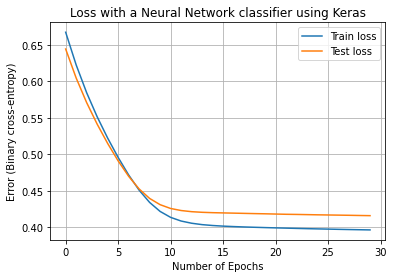

In [0]:
plt.plot(a[2],label='Train loss')
plt.plot(a[3], label = 'Test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Error (Binary cross-entropy)')
plt.grid(True)
plt.legend()
plt.title('Loss with a Neural Network classifier using Keras')
plt.show()

This type of losses graph suggest that there is no overfitting. 

### Comparison of the the 3 classifiers

Unsurprisingly, the optimized neural network achieves the highest score. The 'Random Forest' model, optimized by GridSearch, ranks second with a performance very close to that of the neural network. Finally, the linear classifier achieves a much lower performance.

It should be noted that the evaluation of these three models was carried out under identical conditions: 

1.   Same number of data to run the models (rather small number due to computational issues related to the use of Google Colab).
2.   Same sizes for the training and test samples.



Transforming the comparison dictionary in a Pandas DataFrame.

In [0]:
def comparaison(d):
  a = pd.DataFrame(d, index = ['Accuracy', 'F1 Score', 'Recall', 'Precision'])
  return a

In [0]:
comparaison(d_comparaison)

,Random_Forest,Linear_classifier,Neural_Network_classifier
Accuracy,0.84,0.61,0.85
F1 Score,0.47,0.48,0.46
Recall,0.50,0.50,0.50
Precision,0.51,0.50,0.43


**Conclusive elements**

**This section only mobilized the New York Times comments database (April 2017). Its purpose was to predict, from the body of the commentary, whether the commentary received at least one like (recommendation) or not. The dataset was unbalanced as 22% of the data was labeled 0 and 78% was labeled one. To compute the prediction, the first step consisted in constructing a binary variable based on the 'Recommendations' variable by entering a 0 for comments that did not receive any like, and a 1 for other comments. The choice of such an approach is obviously debatable. For instance:**


1.   Why not try to predict the exact number of likes received per comment? The RAM available on Google Colab did not allow us to mobilize an enough large database, which made training our models impossible.
2.   Why choose the distinction between comments that received no likes and others? For example, we could have tried to predict if the comment had received less than 5 likes, or not. But this seemed less worthwhile to us. 

**Note that the distribution of the number of likes per comment allowed us to explore these questions. As a reminder, and as available at the beginning of this section, 75% of the comments receive strictly less than 10 likes (so a large concentration close to 0). The maximum number of likes received is 7938. 25% of the comments receive 0 or 1 like. The median is 3.**

**Nevertheless, the trained models provide a decent accuracy (around 85% for relevant models and for a 5000 observations data set).**

**Using the Random forest model, we decided to compute our score for an increasing number of observations used.**

**It should be noted that we identified a main problem, due to the fact that the dataset is unbalanced (22% of 0 label, 78% of one label).**
1. Focusing on accuracy is not pertinent because a naive model predicting 1 for every new feature would achieve the same score. Thus, considering accuracy is pertinent if our model overperforms a 0.78 accuracy score, rather than 0.5. 
2. One could consider a strategy in order to rebalance the two classes. That is what we perform next using class_weights, available on SkLearn: ***this is the object of section 1.4.***
3. One could also try to build some features, which is not so easy given the data available. That is what we try in ***section 1.5.***
4. One could also build a model based on balanced classes, separating our data at the median: ***this is the object of subsection 1.6.***



### Evolution of the score when the number of observations increases

In [0]:
# NOT TO BE RUN ONCE AGAIN : COMPUTATIONAL TIME
##############################################
#l_obs = []
#l_accu = []
#l_recall = []
#l_mean = []
#l_index = [10000*i for i in range(1,11)]

#for elem in l_index:
  #l_obs.append(elem)
  #a = random_forest_recommendations(data,elem,0.25)
  #test_rf = a[0]
  #pred_rf = a[1]
  #b = evaluation(test_rf,pred_rf)
  #l_accu.append(b[0])
  #l_recall.append(b[2])
  #l_mean.append(0.77)

In [0]:
# Sauvegarde du résultat 
l_obs = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
l_accu = [0.83, 0.66, 0.7, 0.76, 0.81, 0.84, 0.86, 0.88, 0.89, 0.9]
l_recall = [0.6, 0.66, 0.56, 0.52, 0.51, 0.51, 0.5, 0.5, 0.5, 0.5]
l_mean = [0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77]
l_index = [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]

print(style.BOLD + 'Observations:' + style.END, l_obs)
print(style.BOLD + 'Accuracies:' + style.END, l_accu)
print(style.BOLD + 'Recalls:' + style.END, l_recall)
print(style.BOLD + 'Means:' + style.END, l_mean)
print(style.BOLD + 'Indexes:' + style.END, l_index)



Observations: [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]
Accuracies: [0.83, 0.66, 0.7, 0.76, 0.81, 0.84, 0.86, 0.88, 0.89, 0.9]
Recalls: [0.6, 0.66, 0.56, 0.52, 0.51, 0.51, 0.5, 0.5, 0.5, 0.5]
Means: [0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77]
Indexes: [10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]


**Evolution of the accuracy**

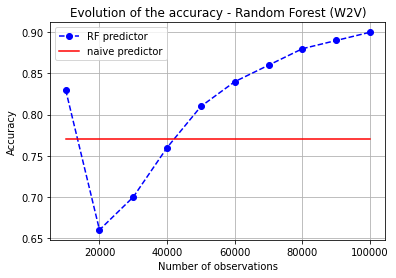

In [0]:
plt.plot(l_obs, l_accu, 'b--o', label = 'RF predictor')
plt.plot(l_obs, l_mean, color = 'r', label = 'naive predictor')
plt.title('Evolution of the accuracy - Random Forest (W2V)')
plt.xlabel('Number of observations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Conclusion:** the model learns something and the accuracy increases when the number of observatIons increases. 

***What do we mean by 'learn something' ?*** We could build a predictor whose task is to predict 1 for each observation. The acuracy computed would be 0.78 as 78% of the observations are labelled 1 ! Thus, if our Random Forest achieved something around 0.78, it would mean that it does not learn much things. 
**When the number of observations increases, the learning improves. A 0.9 accuracy score for an unbalanced dataset is a good result. Unfornately, one can not run the model with more observations due to computational problems (RAM available through Googgle Colab).**

In the next section, we will focus on building a model so as to maximise the recall metrics. Accuracy is not the always consistent in classification problems !

**Evolution of the recall**

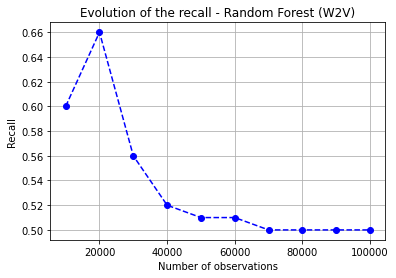

In [0]:
plt.plot(l_obs, l_recall, 'b--o')
plt.title('Evolution of the recall - Random Forest (W2V)')
plt.xlabel('Number of observations')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

## 1.4. Predicting receiving at least one like using class-weight

Class_weight is an option available through Sklearn. Its task is to rebalance the dataset. 

In [0]:
# Importing data.
data = com_ap_17
data = data_process1(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Result

We use the precomputed best parameters set in the last subsection. 

In [0]:
def random_forest_recommendations_classweights(data,n_obs,test_size):
  # Setting the X and y.
  y = data.reco_categ2[0:n_obs]
  X = data.commentBody[0:n_obs]
  print(y.shape)
  print(X.shape)
  # Tokenization.
  print(style.BOLD + '-------- Tokenization --------' + style.END)
  X = tokenization2(X)
  X = [' '.join(ele) for ele in X]
  # Split train-test.
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  print("La longueur de l'échantillon train est : {0}".format(len(X_train)))
  print("La longueur de l'échantillon de test est : {0}".format(len(X_test)))
  # CountVectorizer.
  from sklearn.feature_extraction.text import CountVectorizer
  # Ca prend les phrases du corpus en ligne, en features tous les mots du corpus.
  # Pour chaque ligne, en fonction de la feature, on a le nombre d'apparition du mot 
  # de la feature.
  X_train_cv, X_test_cv = w2v(X_train, X_test)
  #count_vectorizer = CountVectorizer()
  #X_train_cv = count_vectorizer.fit_transform(X_train)
  #X_test_cv = count_vectorizer.transform(X_test)
  # Training the model.
  print(style.BOLD + '-------- Training the model --------' + style.END)
  from sklearn.ensemble import RandomForestClassifier
  rfc = RandomForestClassifier(n_estimators=100, max_depth=None, criterion = 'gini',random_state=42, n_jobs=-1, verbose=1, class_weight="balanced")
  rfc.fit(X_train_cv, y_train)
  # Prediction part.
  print(style.BOLD + '-------- Prediction part --------' + style.END)
  y_test_pred = rfc.predict(X_test_cv)
  y_test_list = y_test.tolist()
  y_test_pred_list = y_test_pred.tolist()
  return y_test_list, y_test_pred_list

Let us fit a random forest using the class_weights option.

In [0]:
a = random_forest_recommendations_classweights(data,5000,0.25)
test_rf = a[0]
pred_rf = a[1]

  7%|▋         | 370/5000 [00:00<00:01, 3696.01it/s]

(5000,)
(5000,)
-------- Tokenization --------


  8%|▊         | 288/3750 [00:00<00:01, 2876.61it/s]

La longueur de l'échantillon train est : 3750
La longueur de l'échantillon de test est : 1250


100%|██████████| 3750/3750 [00:01<00:00, 2823.45it/s]


-------- Training the model --------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.0s


-------- Prediction part --------


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [0]:
evaluation(test_rf,pred_rf)

Accuracy: 0.86
F1 Score: 0.47
Recall: 0.5
Precision: 0.93
--------


(0.86, 0.47, 0.5, 0.93)

In [0]:
d = {}
d['Random_Forest_Balanced'] = evaluation(test_rf,pred_rf)

Accuracy: 0.86
F1 Score: 0.47
Recall: 0.5
Precision: 0.93
--------


### Comparison of performances 

Between the 'normal' Random Forest and the class_weights 'balanced' one. 

In [0]:
a = random_forest_recommendations(data, 5000, 0.25)
test_rf = a[0]
pred_rf = a[1]

  7%|▋         | 355/5000 [00:00<00:01, 3542.56it/s]

(5000,)
(5000,)
-------- Tokenization --------


  7%|▋         | 255/3750 [00:00<00:01, 2546.43it/s]

La longueur de l'échantillon train est : 3750
La longueur de l'échantillon de test est : 1250


100%|██████████| 3750/3750 [00:01<00:00, 2783.43it/s]


-------- Training the model --------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.5s


-------- Prediction part --------


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


In [0]:
evaluation(test_rf, pred_rf)
d['Random_Forest_Normal'] = evaluation(test_rf, pred_rf)

Accuracy: 0.86
F1 Score: 0.47
Recall: 0.5
Precision: 0.52
--------
Accuracy: 0.86
F1 Score: 0.47
Recall: 0.5
Precision: 0.52
--------


In [0]:
comparaison(d)

,Random_Forest_Balanced,Random_Forest_Normal
Accuracy,0.86,0.86
F1 Score,0.47,0.47
Recall,0.50,0.50
Precision,0.93,0.52


**Conclusion:** the 'class_weights' option does not produce better results for the accuracy but increases the Precision score a lot! Thus, regarding Precision, this is a good way to improve results.

## 1.5. Adding features to improve prediction

Loading data.

In [0]:
data = com_ap_17
data = data_process1(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Building Features - Feature Engeneering

**Feature choice:**

Let us check if the length of the comment body is of equal length for observations labelled 1 and 0. 
We are also checking if the number of words is quite similar for the two categories, by identifying the average number of (' ') spaces per comment. 

Otherwise, we will also use other variables directly available in the dataset such as :
1. Editor's pick. A binary variable stating whether the comment was promoted by the NYT or not.
2. The type of the comment. A categorical variable stating whether the comment is an original one, a user reply or a reporter reply.
3. Depth. A variable to characterize the depth of the comment. For instance, the depth of 2 would mean that the comment was posted as a reply to another comment whereas a depth of 3 would mean that comment was in reply to a comment that was itself a reply.
4. The count of replies.



**Length of the commentBody.**

The next piece of code purposes some statistics about the length of the commentBody variable per category. 

 ------ Category 0 ------
Mean length - category 0 389.97
Standard deviation length - category 0 372.34
Maximal length - category 0 1994
Minimal length - category 0 1
25% quantile length - category 0 117.0
Median length - category 0 261.0
75% quantile length - category 0 538.0
------------
 ------ Category 1 ------
Mean length - category 1 442.21
Standard deviation length - category 1 379.85
Maximal length - category 1 1998
Minimal length - category 1 1
25% quantile length - category 1 154.0
Median length - category 1 326.0
75% quantile length - category 1 609.0
------------
 ------ Distribution - Category 0 ------


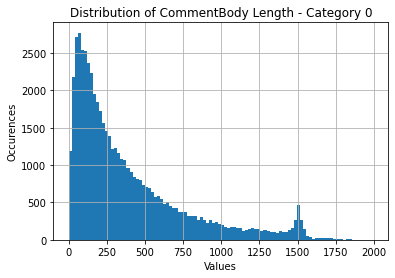

 ------ Distribution - Category 1 ------


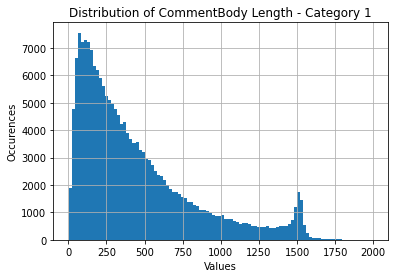

In [0]:
# Identifying mean length per category
l_0 = []
l_1 = []
for i in range(len(data)):
  if data.reco_categ2[i] == 1:
    l_1.append(len(data.commentBody[i]))
  else:
    l_0.append(len(data.commentBody[i]))

print(style.BOLD + ' ------ Category 0 ------' + style.END)
print(style.BOLD + 'Mean length - category 0' + style.END, round(np.mean(l_0),2))
print(style.BOLD + 'Standard deviation length - category 0' + style.END, round(np.std(l_0),2))
print(style.BOLD + 'Maximal length - category 0' + style.END, round(max(l_0),2))
print(style.BOLD + 'Minimal length - category 0' + style.END, round(min(l_0),2))
print(style.BOLD + '25% quantile length - category 0' + style.END, round(np.quantile(l_0,0.25),2))
print(style.BOLD + 'Median length - category 0' + style.END, round(np.quantile(l_0,0.5),2))
print(style.BOLD + '75% quantile length - category 0' + style.END, round(np.quantile(l_0,0.75),2))
print(style.BOLD + '------------' + style.END)
print(style.BOLD + ' ------ Category 1 ------' + style.END)
print(style.BOLD + 'Mean length - category 1' + style.END, round(np.mean(l_1),2))
print(style.BOLD + 'Standard deviation length - category 1' + style.END, round(np.std(l_1),2))
print(style.BOLD + 'Maximal length - category 1' + style.END, round(max(l_1),2))
print(style.BOLD + 'Minimal length - category 1' + style.END, round(min(l_1),2))
print(style.BOLD + '25% quantile length - category 1' + style.END, round(np.quantile(l_1,0.25),2))
print(style.BOLD + 'Median length - category 1' + style.END, round(np.quantile(l_1,0.5),2))
print(style.BOLD + '75% quantile length - category 1' + style.END, round(np.quantile(l_1,0.75),2))
print(style.BOLD + '------------' + style.END)

# Plots of the distribution.
print(style.BOLD + ' ------ Distribution - Category 0 ------' + style.END)
plt.hist(l_0, bins = 100)
plt.title('Distribution of CommentBody Length - Category 0')
plt.xlabel('Values')
plt.ylabel('Occurences')
plt.grid(True)
plt.show()
print(style.BOLD + ' ------ Distribution - Category 1 ------' + style.END)
plt.hist(l_1, bins = 100)
plt.title('Distribution of CommentBody Length - Category 1')
plt.xlabel('Values')
plt.ylabel('Occurences')
plt.grid(True)
plt.show()




Our intuition is that including the length of the commentBody as an explicative variable could make our models improve their prediction power, as the difference between the 2 categories is quite significative.

**Number of words per comment**

The following piece of code provides the number of words per comment and per category, by identifying the number of spaces per comment.

 ------ Category 0 ------
Mean number of words - category 0 62.51
Standard deviation number of words - category 0 60.15
Maximal number of words - category 0 642
Minimal number of words - category 0 0
25% quantile number of words - category 0 19.0
Median number of words - category 0 43.0
75% quantile number of words - category 0 85.0
------------
 ------ Category 1 ------
Mean number of words - category 1 74.39
Standard deviation number of words - category 1 63.67
Maximal number of words - category 1 669
Minimal number of words - category 1 0
25% quantile number fo words - category 1 26.0
Median number of words - category 1 55.0
75% quantile number of words - category 1 103.0
------------
 ------ Distribution - Category 0 ------


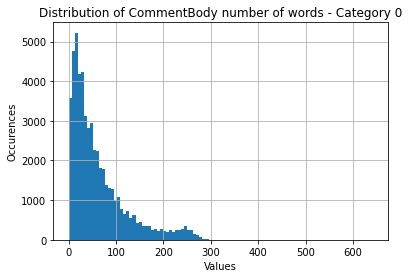

 ------ Distribution - Category 1 ------


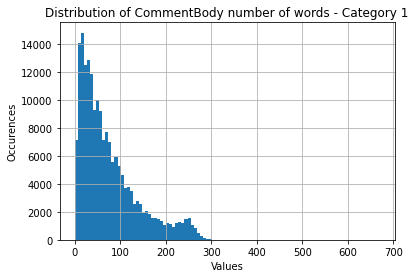

In [0]:
l_0 = []
l_1 = []
for i in range(len(data)):
  if data.reco_categ2[i] == 1:
    somme = 0
    for elem in data.commentBody[i]:
      if elem == ' ':
        somme += 1
    l_1.append(somme)
  else:
    somme = 0
    for elem in data.commentBody[i]:
      if elem == ' ':
        somme += 1
    l_0.append(somme)

print(style.BOLD + ' ------ Category 0 ------' + style.END)
print(style.BOLD + 'Mean number of words - category 0' + style.END, round(np.mean(l_0),2))
print(style.BOLD + 'Standard deviation number of words - category 0' + style.END, round(np.std(l_0),2))
print(style.BOLD + 'Maximal number of words - category 0' + style.END, round(max(l_0),2))
print(style.BOLD + 'Minimal number of words - category 0' + style.END, round(min(l_0),2))
print(style.BOLD + '25% quantile number of words - category 0' + style.END, round(np.quantile(l_0,0.25),2))
print(style.BOLD + 'Median number of words - category 0' + style.END, round(np.quantile(l_0,0.5),2))
print(style.BOLD + '75% quantile number of words - category 0' + style.END, round(np.quantile(l_0,0.75),2))
print(style.BOLD + '------------' + style.END)
print(style.BOLD + ' ------ Category 1 ------' + style.END)
print(style.BOLD + 'Mean number of words - category 1' + style.END, round(np.mean(l_1),2))
print(style.BOLD + 'Standard deviation number of words - category 1' + style.END, round(np.std(l_1),2))
print(style.BOLD + 'Maximal number of words - category 1' + style.END, round(max(l_1),2))
print(style.BOLD + 'Minimal number of words - category 1' + style.END, round(min(l_1),2))
print(style.BOLD + '25% quantile number fo words - category 1' + style.END, round(np.quantile(l_1,0.25),2))
print(style.BOLD + 'Median number of words - category 1' + style.END, round(np.quantile(l_1,0.5),2))
print(style.BOLD + '75% quantile number of words - category 1' + style.END, round(np.quantile(l_1,0.75),2))
print(style.BOLD + '------------' + style.END)

# Plots of the distribution.
print(style.BOLD + ' ------ Distribution - Category 0 ------' + style.END)
plt.hist(l_0, bins = 100)
plt.title('Distribution of CommentBody number of words - Category 0')
plt.xlabel('Values')
plt.ylabel('Occurences')
plt.grid(True)
plt.show()
print(style.BOLD + ' ------ Distribution - Category 1 ------' + style.END)
plt.hist(l_1, bins = 100)
plt.title('Distribution of CommentBody number of words - Category 1')
plt.xlabel('Values')
plt.ylabel('Occurences')
plt.grid(True)
plt.show()

**Editor's pick**

Remember that this variable states whether a comment was promoted by the NYT or not. We think it could have a significant correlation with the target variable (number of upvotes, number of likes, recommendations).

In [0]:
data.editorsSelection = data.editorsSelection.astype(int)

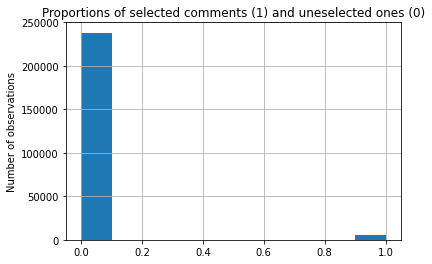

In [0]:
plt.hist(data.editorsSelection)
plt.title('Proportions of selected comments (1) and uneselected ones (0)')
plt.ylabel('Number of observations')
plt.grid(True)
plt.show()

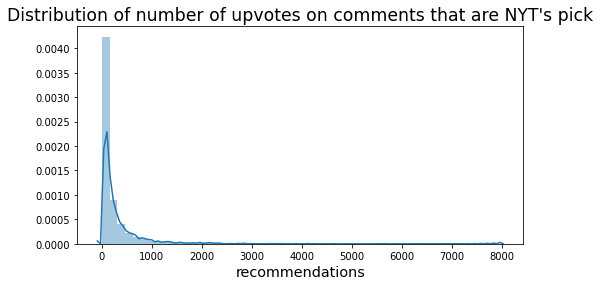

In [0]:
import seaborn as sns

plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['axes.labelsize'] = 'x-large'
sns.distplot(data.loc[data.editorsSelection == 1, 'recommendations']);
plt.title("Distribution of number of upvotes on comments that are NYT's pick");

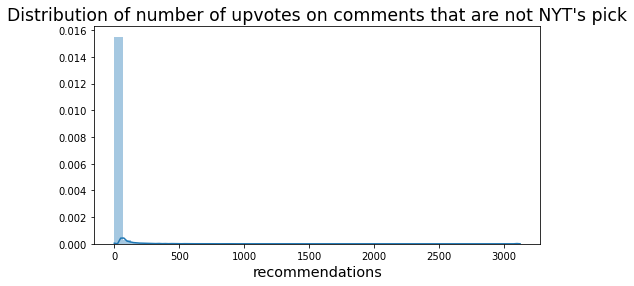

In [0]:
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['axes.labelsize'] = 'x-large'
sns.distplot(data.loc[data.editorsSelection == 0, 'recommendations']);
plt.title("Distribution of number of upvotes on comments that are not NYT's pick");

It suggests to observe the correlation between the number of upvotes (recommendations variable which is the target) and the editorSelection one.  We will check it later.

**Comment Type**

There are three types of comments.

1. Original comments.
2. User replies.
3. Reporter replies.

In [0]:
data.commentType.value_counts()

comment          173277
userReply         70514
reporterReply        41
Name: commentType, dtype: int64

In [0]:
# Quick categorization
data['comment_type'] = pd.Series([0 for x in range(len(data))])
for i in range(len(data)):
  if data.commentType[i] == 'comment':
    data.comment_type[i] += 1
  elif data.commentType[i] == 'userReply':
    data.comment_type[i] += 2
  else:
    data.comment_type[i] +=3

  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**Proportions of comment types and average number of type of comments**

Proportions of comment types

In [0]:
print('Comment')
print(round(len(data[data.commentType == 'comment'])/len(data),2), '%')
print('User Reply')
print(round(len(data[data.commentType == 'userReply'])/len(data),2), '%')
print('Reporter Reply')
print(round(len(data[data.commentType == 'reporterReply'])/len(data),5), '%')

Comment
0.71 %
User Reply
0.29 %
Reporter Reply
0.00017 %


Average number of type of comments

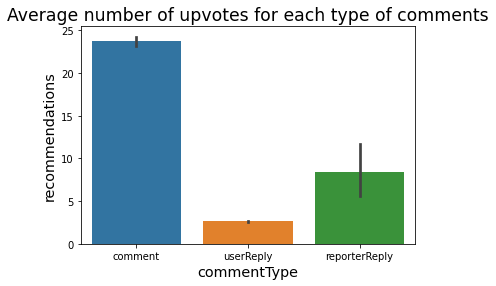

In [0]:
plt.rcParams['figure.figsize'] = (6, 4)
sns.barplot(x = 'commentType', y = 'recommendations', data = data);
plt.title("Average number of upvotes for each type of comments");

In [0]:
data.commentType.value_counts()

comment          173277
userReply         70514
reporterReply        41
Name: commentType, dtype: int64

**Depth**

***Explaination:*** for instance, the depth of 2 would mean that the comment was posted as a reply to another comment whereas a depth of 3 would mean that comment was in reply to a comment that was itself a reply.

In [0]:
data.depth.value_counts()

1    173277
2     70539
3        16
Name: depth, dtype: int64

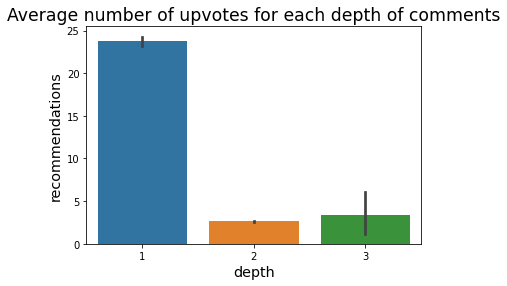

In [0]:
plt.rcParams['figure.figsize'] = (6, 4)
sns.barplot(x = 'depth', y = 'recommendations', data = data);
plt.title("Average number of upvotes for each depth of comments");

**Reply count**

In [0]:
data.replyCount.value_counts()

 0.0      202339
 1.0       22716
 2.0        8492
 3.0        3881
 4.0        2139
           ...  
 75.0          1
 150.0         1
-115.0         1
 68.0          1
 78.0          1
Name: replyCount, Length: 79, dtype: int64

In [0]:
print('Average number of replies per comment:', round(np.mean(data.replyCount),2))

Average number of replies per comment: 0.41


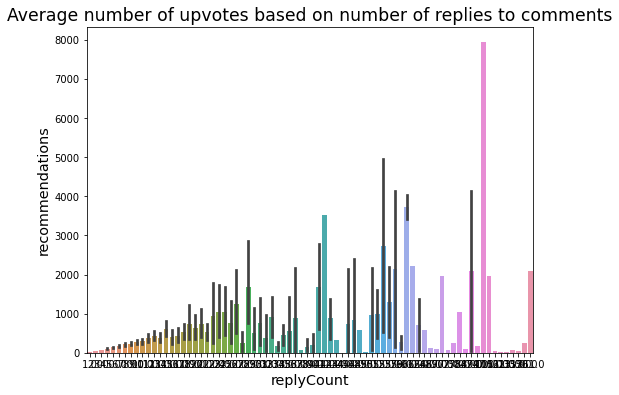

In [0]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['axes.labelsize'] = 'x-large'
sns.barplot(x = 'replyCount', y = 'recommendations', data = data[data.replyCount>0]);
plt.title("Average number of upvotes based on number of replies to comments");

### Correlations between selected features and the target variable

We have to include these new variables in the dataset by applying the following processing function.

In [0]:
def data_process_1_add_features(data):
  # Creating a binary variable (0 - 1)
  data['reco_categ2'] = pd.Series([0 for x in range(len(data))])
  for i in range(len(data)):
    if data['recommendations'][i] == 0:
      data['reco_categ2'][i] += 0
    else:
      data['reco_categ2'][i] += 1
  # Length variable:
  data['length'] = pd.Series([0 for x in range(len(data))])
  for i in range(len(data)):
    data['length'][i] += len(data.commentBody[i])
  # Number of words:
  data['n_words'] = pd.Series([0 for x in range(len(data))])
  for i in range(len(data)):
    somme = 0
    for elem in data.commentBody[i]:
      if elem == ' ':
        somme += 1
    data['n_words'][i] += somme
  # Comment type
  data['comment_type'] = pd.Series([0 for x in range(len(data))])
  for i in range(len(data)):
    if data.commentType[i] == 'comment':
      data.comment_type[i] += 1
    elif data.commentType[i] == 'userReply':
      data.comment_type[i] += 2
    else:
      data.comment_type[i] +=3
  # Some exploration.
  data.editorsSelection = data.editorsSelection.astype(int)
  return data

Processing data

In [0]:
data = com_ap_17
data = data_process_1_add_features(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarn

The following function produces a DataFrame so as to present the correlations between features and the target.

In [0]:
def comparaison_correl(d):
  a = pd.DataFrame(d, index = ['Correlation'])
  return a

In [0]:
d_correlation = {}
d_correlation['Editor pick'] = round(data.editorsSelection.corr(data.recommendations),2)
d_correlation['Length of the commentBody'] = round(data.length.corr(data.recommendations),2)
d_correlation['Number of words'] = round(data.n_words.corr(data.recommendations),2)
d_correlation['Comment Type'] = round(data.comment_type.corr(data.recommendations),2)
d_correlation['Depth'] = round(data.depth.corr(data.recommendations),2)
d_correlation['Reply Count'] = round(data.replyCount.corr(data.recommendations),2)
a = comparaison_correl(d_correlation)

In [0]:
res = pd.melt(a)
res.columns = ['Variable', 'Correlation with recommendations']
res

,Variable,Correlation with recommendations
0,Editor pick,0.34
1,Length of the commentBody,0.06
2,Number of words,0.06
3,Comment Type,-0.10
4,Depth,-0.10
5,Reply Count,0.41


**Remarks:** all these variables are significantly correlated with the target. In particular, Editor Pick and Reply Count seem to be highly correlated.

### Random Forest - Results and comparison

In [0]:
data = com_ap_17
data = data_process_1_add_features(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarn

The following Embedder function computes the w2v embedding directly so it is easier to use the result as an input in the Random Forest.

In [0]:
def embedder(data, n_obs, test_size):
  X = data.commentBody[0:n_obs]
  split = int(test_size*len(X))
  print(type(X))
  X_train, X_test = X[split:], X[:split]
  X_train = tokenization2(X_train)
  X_test = tokenization2(X_test)
  X_train = [' '.join(ele) for ele in X_train]
  X_test = [' '.join(ele) for ele in X_test]
  X_train_cv, X_test_cv = w2v(X_train, X_test)
  X = X_train_cv + X_test_cv
  print(len(X_train_cv))
  print(len(X_test_cv))
  #print(len(X))
  #print(type(X))
  return X

In [0]:
def random_forest_recommendations_add_features(data,n_obs,test_size):
  # Setting the X and y.
  y = data.reco_categ2[0:n_obs]
  y = pd.DataFrame(y)
  X1 = embedder(data, n_obs, test_size)
  X2 = data.length[0:n_obs]
  X3 = data.n_words[0:n_obs]
  X4 = data.editorsSelection[0:n_obs]
  X5 = data.comment_type[0:n_obs]
  X6 = data.depth[0:n_obs]
  X7 = data.replyCount[0:n_obs]
  X1 = np.array(X1)
  X = np.column_stack((X1,X2,X3,X4,X5,X6,X7))
  X = pd.DataFrame(X)
  split = int(test_size*len(data[0:n_obs]))
  X_train, X_test, y_train, y_test = X[split:], X[:split], y[split:], y[:split]
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.preprocessing import StandardScaler
  sc = StandardScaler()
  rfc = RandomForestClassifier(n_estimators=100, max_depth=None, criterion = 'gini',random_state=42, n_jobs=-1, verbose=1)
  rfc.fit(X_train, y_train)
  y_test_pred = rfc.predict(X_test)
  l_test = []
  for elem in y_test.reco_categ2:
    l_test.append(elem)
  return l_test, y_test_pred

In [0]:
a = random_forest_recommendations_add_features(data, 5000, 0.25)

  9%|▊         | 321/3750 [00:00<00:01, 3208.37it/s]

<class 'pandas.core.series.Series'>


100%|██████████| 3750/3750 [00:01<00:00, 2873.57it/s]


3750
1250


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Let us compute a comparison between the Random forest with features (built in this subsection) and the one with only 1 feature (the commentBody) to check the result of adding features. 


In [0]:
d = {}

a = random_forest_recommendations_add_features(data, 30000, 0.25)
test_rf_features = a[0]
pred_rf_features = a[1]
res = evaluation(test_rf_features, pred_rf_features)
d['6 Features RF'] = res

b = random_forest_recommendations(data, 30000, 0.25)
test_rf = b[0]
pred_rf = b[1]
res = evaluation(test_rf, pred_rf)
d['1 Feature RF'] = res
d = comparaison(d)

  1%|▏         | 300/22500 [00:00<00:07, 2998.89it/s]

<class 'pandas.core.series.Series'>


100%|██████████| 22500/22500 [00:08<00:00, 2662.10it/s]


22500
7500


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
  1%|▏         | 391/30000 [00:00<00:07, 3900.18it/s]

Accuracy: 0.83
F1 Score: 0.47
Recall: 0.51
Precision: 0.57
--------
(30000,)
(30000,)
-------- Tokenization --------


  1%|▏         | 298/22500 [00:00<00:07, 2964.93it/s]

La longueur de l'échantillon train est : 22500
La longueur de l'échantillon de test est : 7500


100%|██████████| 22500/22500 [00:08<00:00, 2744.60it/s]


-------- Training the model --------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


-------- Prediction part --------
Accuracy: 0.82
F1 Score: 0.52
Recall: 0.54
Precision: 0.78
--------


Printing the comparison.

In [0]:
d

,6 Features RF,1 Feature RF
Accuracy,0.83,0.82
F1 Score,0.47,0.52
Recall,0.51,0.54
Precision,0.57,0.78


**Conclusion:** our Random Forests are built so as to maximize the accuracy. Adding two more features increase a little bit the accuracy, but not so much. Classes are unbalanced (77%-23%). Hence, performing an accuracy most important than 0.77 is a performance but for such unbalanced classes, one could also focus on the recall metrics.

## 1.6. Predicting likes with balanced classes

As a reminder, the median for the initial variable 'Recommendations' is 3. The first step consists of binaziring based on this observation.

In [0]:
data = com_ap_17

In [0]:
somme = 0
for i in range(len(data)):
  if data.recommendations[i] > 3:
    somme +=1 
print(round(somme/len(data),2))

0.48


48% of the comments have more than 3 likes. Hence the following binarization. Objective: get balanced classes.

In [0]:
def binarization_1_5(data):
  data['reco_categ3'] = pd.Series([0 for x in range(len(data))])
  for i in range(len(data)):
    if data.recommendations[i] > 3:
      data.reco_categ3[i] += 1
  return data


### Random Forest setup
We are gonna use the same optimized parameters as before.

**Best parameters:**

1.   n_estimators = 100
2.   criterion = 'gini'


In [0]:
data = binarization_1_5(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
def random_forest_1_5(data,n_obs,test_size):
  # Setting the X and y.
  y = data.reco_categ3[0:n_obs]
  X = data.commentBody[0:n_obs]
  print(y.shape)
  print(X.shape)
  # Tokenization.
  print(style.BOLD + '-------- Tokenization --------' + style.END)
  X = tokenization2(X)
  X = [' '.join(ele) for ele in X]
  # Split train-test.
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  print("La longueur de l'échantillon train est : {0}".format(len(X_train)))
  print("La longueur de l'échantillon de test est : {0}".format(len(X_test)))
  # CountVectorizer.
  from sklearn.feature_extraction.text import CountVectorizer
  X_train_cv, X_test_cv = w2v(X_train, X_test)
  print(style.BOLD + '-------- Training the model --------' + style.END)
  from sklearn.ensemble import RandomForestClassifier
  rfc = RandomForestClassifier(n_estimators=100, max_depth=None, criterion = 'gini',random_state=42, n_jobs=-1, verbose=1)
  rfc.fit(X_train_cv, y_train)
  # Prediction part.
  print(style.BOLD + '-------- Prediction part --------' + style.END)
  y_test_pred = rfc.predict(X_test_cv)
  y_test_list = y_test.tolist()
  y_test_pred_list = y_test_pred.tolist()
  return y_test_list, y_test_pred_list

In [0]:
a = random_forest_1_5(data,10000,0.25)
test_rf = a[0]
pred_rf = a[1]

  3%|▎         | 347/10000 [00:00<00:02, 3466.06it/s]

(10000,)
(10000,)
-------- Tokenization --------


  4%|▍         | 296/7500 [00:00<00:02, 2945.11it/s]

La longueur de l'échantillon train est : 7500
La longueur de l'échantillon de test est : 2500


100%|██████████| 7500/7500 [00:02<00:00, 2865.13it/s]


-------- Training the model --------


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.7s


-------- Prediction part --------


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [0]:
evaluation(test_rf,pred_rf)

Accuracy: 0.61
F1 Score: 0.6
Recall: 0.6
Precision: 0.61
--------


(0.61, 0.6, 0.6, 0.61)

### Results for the Random Forest

**Not to be run once again (Computational time) !!!!**

In [0]:
l_acu = []
l_mean = []
l_index = [10000* i for i in range(1,11)]
d = {}

for elem in l_index:
  a = random_forest_1_5(data,elem,0.25)
  test_rf = a[0]
  pred_rf = a[1]
  b = evaluation(test_rf, pred_rf)
  l_acu.append(b[0])
  l_mean.append(0.48)
  d['RF' + str(elem) + 'observations'] = b

**Plotting the evolution of the accuracy**

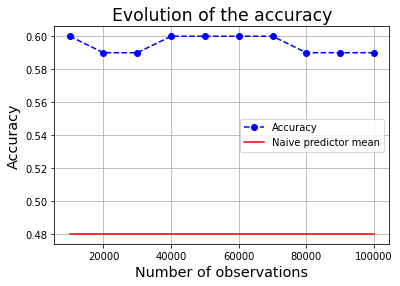

In [0]:
plt.plot(l_index, l_acu, 'b--o', label = 'Accuracy')
plt.plot(l_index, l_mean, color = 'r', label = 'Naive predictor mean')
plt.title('Evolution of the accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of observations')
plt.legend()
plt.grid(True)
plt.show()

**Remarks**: the model overperform because a naive model (predicting always 1) would perform a 0.48 accuracy score. Our results are much better but with such a setup, the reachable accuracy seems to be bounded. It means that others variables, modelling phenomena, play a key role in this classification problem.

**Comparaison**

In [0]:
comparaison(d)

,RF10000observations,RF20000observations,RF30000observations,RF40000observations,RF50000observations,RF60000observations,RF70000observations,RF80000observations,RF90000observations,RF100000observations
Accuracy,0.6,0.59,0.59,0.60,0.60,0.60,0.60,0.59,0.59,0.59
F1 Score,0.6,0.59,0.58,0.59,0.58,0.57,0.58,0.58,0.58,0.58
Recall,0.6,0.59,0.58,0.59,0.59,0.58,0.58,0.59,0.58,0.58
Precision,0.6,0.59,0.59,0.60,0.60,0.59,0.59,0.59,0.59,0.59


### Keras Neural network setup

In [0]:
data = binarization_1_5(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
def NNKeras_classifier_recommendations_1_5(data,n_obs,test_size):
  from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
  # Setting the X and y.
  y = data.reco_categ3[0:n_obs]
  X = data.commentBody[0:n_obs]
  print(y.shape)
  print(X.shape)
  # Tokenization.
  print(style.BOLD + '-------- Tokenization --------' + style.END)
  X = tokenization2(X)
  X = [' '.join(ele) for ele in X]
  # Split train-test.
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  print("La longueur de l'échantillon train est : {0}".format(len(X_train)))
  print("La longueur de l'échantillon de test est : {0}".format(len(X_test)))
  # CountVectorizer.
  from sklearn.feature_extraction.text import CountVectorizer
  # Ca prend les phrases du corpus en ligne, en features tous les mots du corpus.
  # Pour chaque ligne, en fonction de la feature, on a le nombre d'apparition du mot 
  # de la feature.
  #X_train_cv, X_test_cv = w2v(X_train, X_test)
  count_vectorizer = CountVectorizer()
  X_train_cv = count_vectorizer.fit_transform(X_train)
  X_test_cv = count_vectorizer.transform(X_test)
  X_train_cv = X_train_cv.toarray()
  X_test_cv = X_test_cv.toarray()
  #y_test = y_test.toarray()
  #y_train = y_train.toarray()
  # Training the model.
  print(style.BOLD + '-------- Training the model --------' + style.END)
  # Setting the model
  classifier = Sequential()
  classifier.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train_cv.shape[1]))
  classifier.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
  classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
  classifier.compile(optimizer = 'sgd', loss = 'binary_crossentropy', metrics = ['accuracy'])
  history = classifier.fit(X_train_cv, y_train, validation_data = (X_test_cv, y_test), batch_size = 100, epochs = 50, verbose = 2)
  #Getting the losses
  loss_history = history.history['loss']
  loss_history = np.array(loss_history)
  val_loss_history = history.history['val_loss']
  val_loss_history = np.array(val_loss_history)
  # Prediction part.
  print(style.BOLD + '-------- Prediction part --------' + style.END)
  y_test_pred = classifier.predict(X_test_cv)
  y_test_pred = np.where(y_test_pred > 0.5, 1, 0)
  y_test_list = y_test.tolist()
  y_test_pred_list = y_test_pred.tolist()
  y_test_pred_liste = []
  for i in range(len(y_test_pred_list)):
    y_test_pred_liste.append(y_test_pred_list[i][0])
  return y_test_list, y_test_pred_liste, loss_history, val_loss_history

In [0]:
a = NNKeras_classifier_recommendations_1_5(data,20000,0.25)
print(len(a))
test_NN = a[0]
pred_NN = a[1]

  2%|▏         | 360/20000 [00:00<00:05, 3593.22it/s]

(20000,)
(20000,)
-------- Tokenization --------


100%|██████████| 20000/20000 [00:05<00:00, 3415.36it/s]


La longueur de l'échantillon train est : 15000
La longueur de l'échantillon de test est : 5000
-------- Training the model --------
Train on 15000 samples, validate on 5000 samples
Epoch 1/50
 - 8s - loss: 0.6927 - acc: 0.5145 - val_loss: 0.6925 - val_acc: 0.5086
Epoch 2/50
 - 8s - loss: 0.6919 - acc: 0.5180 - val_loss: 0.6920 - val_acc: 0.5086
Epoch 3/50
 - 8s - loss: 0.6912 - acc: 0.5180 - val_loss: 0.6916 - val_acc: 0.5086
Epoch 4/50
 - 8s - loss: 0.6906 - acc: 0.5180 - val_loss: 0.6911 - val_acc: 0.5086
Epoch 5/50
 - 8s - loss: 0.6899 - acc: 0.5180 - val_loss: 0.6906 - val_acc: 0.5086
Epoch 6/50
 - 8s - loss: 0.6891 - acc: 0.5180 - val_loss: 0.6899 - val_acc: 0.5086
Epoch 7/50
 - 8s - loss: 0.6882 - acc: 0.5180 - val_loss: 0.6892 - val_acc: 0.5086
Epoch 8/50
 - 8s - loss: 0.6873 - acc: 0.5191 - val_loss: 0.6885 - val_acc: 0.5142
Epoch 9/50
 - 8s - loss: 0.6864 - acc: 0.5359 - val_loss: 0.6878 - val_acc: 0.5340
Epoch 10/50
 - 8s - loss: 0.6856 - acc: 0.5487 - val_loss: 0.6872 - val_

In [0]:
evaluation(test_NN,pred_NN)

Accuracy: 0.59
F1 Score: 0.59
Recall: 0.59
Precision: 0.59
--------


(0.59, 0.59, 0.59, 0.59)

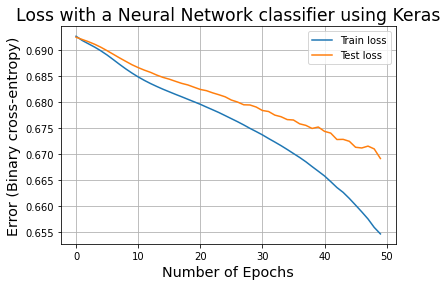

In [0]:
plt.plot(a[2],label='Train loss')
plt.plot(a[3], label = 'Test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Error (Binary cross-entropy)')
plt.grid(True)
plt.legend()
plt.title('Loss with a Neural Network classifier using Keras')
plt.show()

**Same results.**

### Logistic Regression setup

In [0]:
data = binarization_1_5(data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
from sklearn.linear_model import LogisticRegression
def log_reg_1_5(data,n_obs,test_size):
  # Setting the X and y.
  y = data.reco_categ3[0:n_obs]
  X = data.commentBody[0:n_obs]
  print(y.shape)
  print(X.shape)
  # Tokenization.
  print(style.BOLD + '-------- Tokenization --------' + style.END)
  X = tokenization2(X)
  X = [' '.join(ele) for ele in X]
  # Split train-test.
  from sklearn.model_selection import train_test_split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
  print("La longueur de l'échantillon train est : {0}".format(len(X_train)))
  print("La longueur de l'échantillon de test est : {0}".format(len(X_test)))
  # CountVectorizer.
  from sklearn.feature_extraction.text import CountVectorizer
  # Ca prend les phrases du corpus en ligne, en features tous les mots du corpus.
  # Pour chaque ligne, en fonction de la feature, on a le nombre d'apparition du mot 
  # de la feature.
  X_train_cv, X_test_cv = w2v(X_train, X_test)
  #count_vectorizer = CountVectorizer()
  #X_train_cv = count_vectorizer.fit_transform(X_train)
  #X_test_cv = count_vectorizer.transform(X_test)
  # Training the model.
  print(style.BOLD + '-------- Training the model --------' + style.END)
  clf = LogisticRegression(random_state=0).fit(X_train_cv, y_train)
  # Prediction part.
  print(style.BOLD + '-------- Prediction part --------' + style.END)
  y_test_pred = clf.predict(X_test_cv)
  y_test_list = y_test.tolist()
  y_test_pred_list = y_test_pred.tolist()
  return y_test_list, y_test_pred_list

In [0]:
a = log_reg_1_5(data,40000,0.25)
test_reg = a[0]
pred_reg = a[1]

  1%|          | 385/40000 [00:00<00:10, 3832.41it/s]

(40000,)
(40000,)
-------- Tokenization --------


  1%|          | 289/30000 [00:00<00:10, 2880.44it/s]

La longueur de l'échantillon train est : 30000
La longueur de l'échantillon de test est : 10000


100%|██████████| 30000/30000 [00:11<00:00, 2701.05it/s]


-------- Training the model --------
-------- Prediction part --------


In [0]:
evaluation(test_rf, pred_rf)

Accuracy: 0.59
F1 Score: 0.58
Recall: 0.58
Precision: 0.59
--------


(0.59, 0.58, 0.58, 0.59)

### Conclusion

Naive models (predicting 1 each time) would perform a 0.48 accuracy result. Our best models (Logistic regression and optimized Random Forest) perform an accuracy of about 0.6. These results can be explained because:

1. Of a low quality of our word Embeddings, which is not a credible hypothesis as the two ones used (W2V and CountVectorizer) are pre-trained.
2. The target is not really predictable as it is the result of random behaviors (credible in our point of view).
3. Not enough features available so as to be able to increase the quality of prediction.
4. Not enough data available. 

## 1.7.Conclusive elements

This part was dedicated to the prediction of the binary 'recommendations' variable, stating whether a comment was received at least one like or not. We began by explorating the comment dataset and editing some statistics regarding the target variable. 

After cleaning and word embedding, our first approach consisted in predicting the target using as unique feature the commentBody variable. We performed this task using three different classifiers: an optimized Random Forest, a linear classifier and a Keras Neural Network. The linear classifier produced bad results and was not pertinent because a naive model would have produced better results, due to the fact that classes were unbalanced (77%-23%). Hence, considering accuracy as the evaluation metrics, a model is considered to be performant if it produces an accuracy greater than 0.77 on the test set. This is the case for the Random Forest and the Neural Network. 

Two main problems were faced: 
1. Unbalanced classes.
2. RAM available through Google Colab.

In order to increase our prediction power, next steps were dedicated to:
1. Use some technics to rebalance the classes. It did not increase accuracy a lot but increased precision!
2. Adding some features. This was made in section 1.5. Prediction power increases a little bit. 

When pertinent models were used, we always overperformed naive predictors, hence our models 'learn something' which is a good point, meaning the learning is correctly realized. 

In order to increase scores, here are some ideas that could be used: 
1. Get a more important RAM so as to be able to run models with a very large number of data. 
2. Find new features. 

# 2.Sentiment Analysis.

This part is dedicated to sentiment analyzis and is a prospective work. The main goal was to use the sentiment_score object (which, for a gibven text, produces a sentiment score between -1 and 1), available through NLTK, to explore the sentiment scores distribution both for the comment database and the article one. 

Here are the main questions for which we provided an answer:

1. In average, is the sentiment score equal for articles and comments ?
2. Which are articles headlines producing extreme sentiments (best and worst). 
3. Among the top Keywords (most frequent keywords) articles, what is the sentiment score distribution ?
4. Which themes produce extreme sentiments ?
5. Do top Keywords generate in average the same number of sentiments ?
6. What are Keywords generating the most commments and their associated sentiment score ?

## 2.1. Setup and preprocessing

### Preprocessing - Articles database

Importing data

In [0]:
articles = art_ap_17
comments = com_ap_17
articles['pubDate'] = pd.to_datetime(articles['pubDate'])

Sentiment analyzer from NLTK. The function attributes a sentiment score and will be used next to proceed to sentiment analysis.

In [0]:
import nltk
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
def sentiment_score(text):
    return sid.polarity_scores(text)['compound']

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Preprocessing (articles database). It includes dropping some unuseful variables, missing observations, applying the sentiment score function from NLTK.

In [0]:
articles = articles[articles['keywords'] != '[]'].reset_index()
articles['keywords'] = articles['keywords'].replace(r'\[\'|\'\]', '', regex=True).str.split(r'\',\s\'')
articles.dropna(axis=1, inplace=True)
articles.drop(['documentType', 'multimedia', 'source', 'webURL', 'snippet'], axis=1, inplace=True)
all_keywords = pd.Series(reduce(concat, articles['keywords']))
articles = pd.DataFrame(articles.values.repeat(articles['keywords'].str.len(), axis=0), columns=articles.columns)
articles = articles.assign(keywords=all_keywords)
articles['sentiment'] = articles['headline'].apply(sentiment_score).astype(float)
articles = articles[~articles['keywords'].str.match(r'^\d+$')]

In [0]:
comments['sentiment']

### Distribution of the sentiments score

Analyzing the distribution of the sentiment score. 

Mean of sentiment scores -0.01
Standard deviation of sentiment scores 0.32
Maximum of sentiment scores 0.86
Minimum of sentiment scores -0.88
Median of sentiment scores 0.0
25% quantile of sentiment scores 0.0
75% quantile of sentiment scores 0.0
----------------


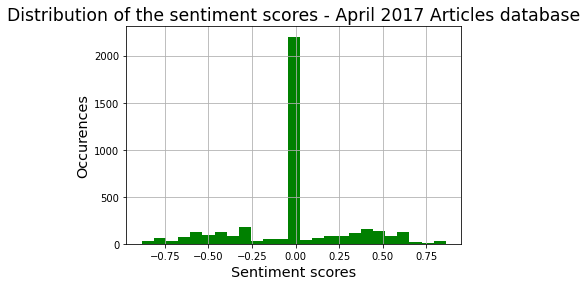

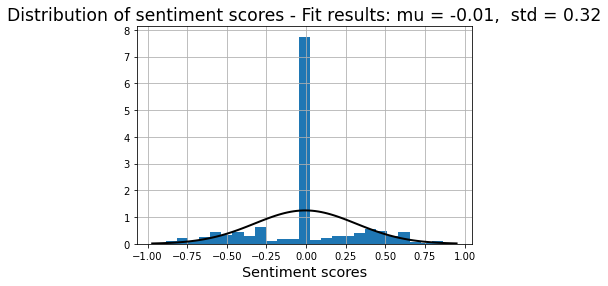

In [0]:
l = []

for i in range(len(articles)):
  l.append(articles.sentiment[i])

from scipy.stats import norm
# Printing useful statistics:
print(style.BOLD + 'Mean of sentiment scores' + style.END, round(np.mean(l),2))
print(style.BOLD + 'Standard deviation of sentiment scores' + style.END, round(np.std(l),2))
print(style.BOLD + 'Maximum of sentiment scores' + style.END, round(max(l),2))
print(style.BOLD + 'Minimum of sentiment scores' + style.END, round(min(l),2))
print(style.BOLD + 'Median of sentiment scores' + style.END, np.quantile(l, 0.5))
print(style.BOLD + '25% quantile of sentiment scores' + style.END, np.quantile(l, 0.25))
print(style.BOLD + '75% quantile of sentiment scores' + style.END, np.quantile(l, 0.75))
print(style.BOLD + '----------------' + style.END)

# Plot of the distribution of sentiment score
plt.hist(l, bins = 25, color = 'green')
plt.title('Distribution of the sentiment scores - April 2017 Articles database')
plt.xlabel('Sentiment scores')
plt.ylabel('Occurences')
plt.grid(True)
plt.show()
mu, std = norm.fit(l)
plt.hist(l, density = True, bins = 25)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Distribution of sentiment scores - Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Sentiment scores')
plt.grid(True)
plt.show()


The gaussian fit is very bad because there is a huge concentration around 0 and because tails are definitively too much big. The following piece of code analyzes the percentage of observations around 0. 

In [0]:
def percentage_around_0(value):
  somme = 0
  for i in range(len(articles)):
    if articles.sentiment[i] > - value and articles.sentiment[i] < value:
      somme += 1
  print(style.BOLD + 'Percentage of observations whose sentiment scores are between [0 - %s, 0+ %s]:' %(str(value), str(value)) + style.END, round(somme/len(articles)*100,2), '%')


In [0]:
l = [0.02, 0.05, 0.1, 0.2]
for elem in l:
  percentage_around_0(elem)

Percentage of observations whose sentiment scores are between [0 - 0.02, 0+ 0.02]: 53.55 %
Percentage of observations whose sentiment scores are between [0 - 0.05, 0+ 0.05]: 54.51 %
Percentage of observations whose sentiment scores are between [0 - 0.1, 0+ 0.1]: 55.98 %
Percentage of observations whose sentiment scores are between [0 - 0.2, 0+ 0.2]: 59.15 %


### Preprocessing - Comments database

It consists of 'normalizing' our comments by dropping NAs from the dataset, unuseful variables for the section and unuseful characters.

In [0]:
comments.dropna(axis=1, inplace = True)
drop_list = ['approveDate', 'articleWordCount', 'commentID', 'commentSequence', 'commentType']
drop_list.extend(['createDate', 'depth', 'inReplyTo', 'newDesk', 'parentID'])
drop_list.extend(['picURL', 'printPage', 'replyCount', 'sharing', 'status', 'timespeople', 'trusted'])
drop_list.extend(['typeOfMaterial', 'updateDate', 'userID'])
comments.drop(drop_list, axis = 1, inplace = True)


In [0]:
comments['commentBody'] = comments['commentBody'].replace(r'<.+>|[^0-9\sA-Za-z]', '', regex=True).str.lower()

## 2.2. Articles database.

### Most frequent words in articles

The following piece of code is a function that returns the most frequent words in the articles database. 

In [0]:
def most_frequent(n_words):
  formattedDate = articles['pubDate'].dt.strftime('%b %d, %Y')
  keyword_df = pd.DataFrame({'pubDate': formattedDate, 'keyword': articles['keywords']})
  axes = keyword_df.groupby([keyword_df['pubDate'].str.slice(8), keyword_df['pubDate'].str.slice(0, 3)]) \
    .apply(lambda g: g['keyword'].value_counts()[:n_words]).iloc[::-1].plot.barh(figsize=(7, 10))
  axes.set_xlabel('Keyword Occurrences')
  axes.set_ylabel('')
  plt.title('Top %s Most Popular Keywords' %(str(n_words)))
  del formattedDate
  del keyword_df
  del axes
  gc.collect()
  plt.show()

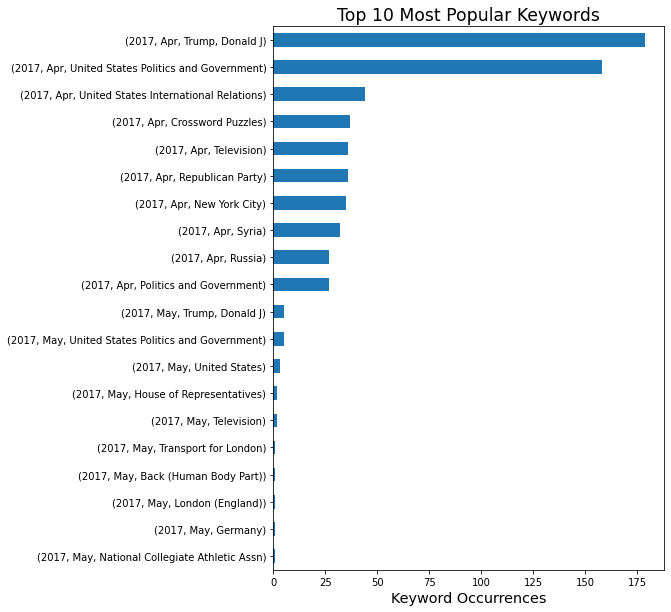

In [0]:
most_frequent(10)

**Remark:** we have a lot of occurences from April 2017, and some of May. This is because the database contains some observations from the beginning of May. 

Concerning the most frequent words, they often seem refer to political topics. Donald Trump is the number one, which is not surprising as this was just after the presidential election period !

In [0]:
def most_frequent_plot(n_words):
  articles['keywords'].value_counts()[:n_words].iloc[::-1].plot.bar(figsize=(8, 4))
  plt.title('Top %s Keywords Overall' %str(n_words))
  plt.ylabel('Keyword Occurences')
  plt.show()

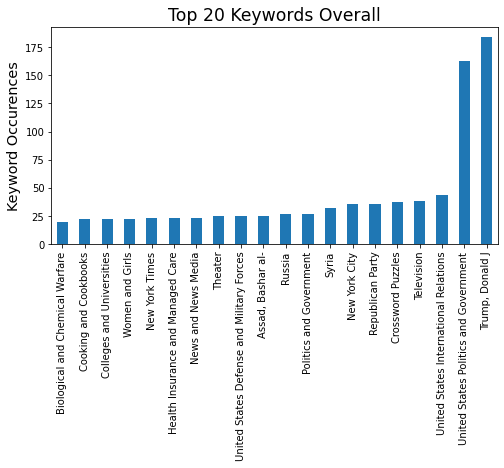

In [0]:
most_frequent_plot(20)

### WordCloud and Camembert (pie) plots

In [0]:
def generate_word_cloud(max_words, height, width):
  wc = WordCloud(max_words = max_words, height = height, width = width, background_color='white').generate(' '.join(articles['keywords']))
  plt.figure(figsize=(10,7))
  plt.title("WordCloud visualization of top keywords - April 2017.", fontsize=14)
  plt.imshow(wc)
  plt.show()

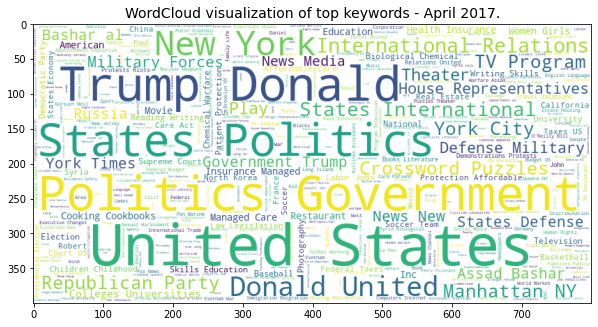

In [0]:
generate_word_cloud(500, 400, 800)

A good vizualization of the top Keywords from the articles database from New York Times, April 2017.

The following piece of code prints the 'Camembert' graph of the top Keywords, both for the front page and the whole pages.

In [0]:
def camembert_top_words_front_page(n_words):
  front_page_keywords = articles[articles['printPage'] == 1]['keywords'].value_counts().iloc[: n_words]
  front_page_keywords.plot.pie(figsize=(5, 4))
  del front_page_keywords
  gc.collect()
  plt.title('Top %s Front Page Keywords' %str(n_words))
  plt.ylabel('')
  plt.show()

def camembert_top_words(n_words):
  front_page_keywords = articles['keywords'].value_counts().iloc[: n_words]
  front_page_keywords.plot.pie(figsize=(5, 4))
  del front_page_keywords
  gc.collect()
  plt.title('Top %s  Keywords' %str(n_words))
  plt.ylabel('')
  plt.show()

Top Keywords - Front Page


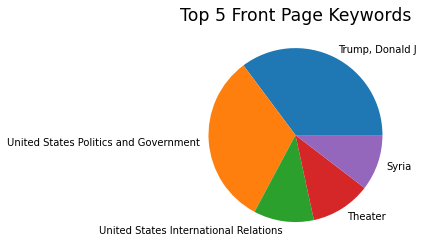

------------------------
Top Keywords - Whole Pages


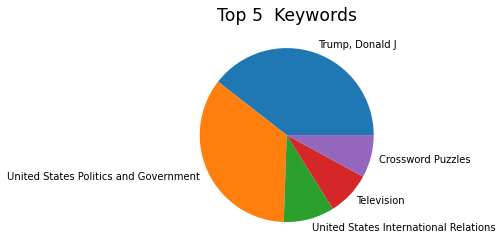

In [0]:
print(style.BOLD + 'Top Keywords - Front Page' + style.END)
camembert_top_words_front_page(5)
print(style.BOLD + '------------------------' + style.END)
print(style.BOLD + 'Top Keywords - Whole Pages' + style.END)
camembert_top_words(5)

### Top Keywords sentiments

In [0]:
l = ['United States Politicss and Government', 'Trump, Donald J',\
     'United States International Relations', 'Crossword Puzzles', 'Television']

Average headline sentiment score for the top 5 keywords is -0.027


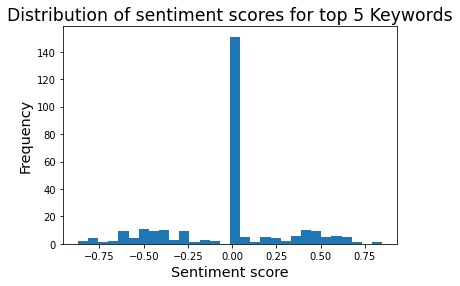

<Figure size 576x504 with 0 Axes>

In [0]:
top_5_keywords = ['United States Politics and Government', 'Trump, Donald J',\
     'United States International Relations', 'Crossword Puzzles', 'Television']
top_5_sentiment = articles[(articles['keywords'].isin(top_5_keywords)) & (articles['headline'] != 'Unknown')].drop_duplicates('headline')
print(style.BOLD + 'Average headline sentiment score for the top 5 keywords is {}'.format(round(top_5_sentiment['sentiment'].mean(), 3)) + style.END)
top_5_sentiment['sentiment'].plot.hist(bins=30)
unique = articles[articles['headline'] != 'Unknown'].drop_duplicates('headline')
plt.title('Distribution of sentiment scores for top 5 Keywords')
plt.xlabel('Sentiment score')
plt.figure(figsize=(8,7))
plt.show()

Top 5 headlines by Positive Sentiment

In [0]:
print(style.BOLD + "Top 5 Headlines by Positive Sentiment:" + style.END, end='\n\n')
for i, row in top_5_sentiment.sort_values('sentiment', ascending=False).iloc[:5].iterrows():
    print(style.BOLD + 'Headline:' + style.END, row['headline'], style.BOLD + 'Sentiment score:' + style.END, row['sentiment'])

Top 5 Headlines by Positive Sentiment:

Headline: Five Decades Ago in Vietnam, a Different Great, Great Wall Sentiment score: 0.8481
Headline: In Highlight for President, Gorsuch Is Sworn In as Court’s 113th Justice Sentiment score: 0.7003
Headline: ‘The Good Fight’ Season 1, Episode 9: Blinding Privilege Sentiment score: 0.6597
Headline: ‘Better Call Saul’ Season 3, Episode 3: A Better Solution Sentiment score: 0.6369
Headline: Trump Versus  the Love Gov Sentiment score: 0.6369


Top 5 headlines by Negative Sentiment

In [0]:
print("Top 5 Headlines by Negative Sentiment:", end='\n\n')
for i, row in top_5_sentiment.sort_values('sentiment').iloc[:5].iterrows():
    print(style.BOLD + 'Headline:' + style.END, row['headline'],style.BOLD + 'Sentiment Score' + style.END, row['sentiment'])


Top 5 Headlines by Negative Sentiment:

Headline: The Bad,  the Worse and The Ugly Sentiment Score -0.872
Headline: ‘Homeland,’ Season 6, Episode 12: In the Finale, Carrie Deals With Death and Betrayal Sentiment Score -0.8271
Headline: The Coming Incompetence Crisis Sentiment Score -0.8126
Headline: Why Is This Hate Different From All Other Hate? Sentiment Score -0.8126
Headline: And Now,  the Dreaded Trump Curse Sentiment Score -0.802


In [0]:
def article_outlier_report(article_df, subset_name):
    article_df = article_df.drop_duplicates('headline')
    iqr = article_df['sentiment'].quantile(0.75) - article_df['sentiment'].quantile(0.25)
    low = article_df['sentiment'].quantile(0.25) - (1.5 * iqr)
    high = article_df['sentiment'].quantile(0.75) + (1.5 * iqr)
    outliers = article_df[(article_df['sentiment'] < low) | (article_df['sentiment'] > high)]
    norms = article_df[(article_df['sentiment'] >= low) & (article_df['sentiment'] <= high)]
    pct_pos = round(float(len(article_df[article_df['sentiment'] > high])) / len(article_df) * 100, 2)
    pct_neg = round(float(len(article_df[article_df['sentiment'] < low])) / len(article_df) * 100, 2)
    pct_outliers = round(float(outliers.shape[0]) / len(article_df) * 100, 2)
    pct_normal = round(float(norms.shape[0]) / len(article_df) * 100, 2)
    report = ""
    report += "{} Outlier Report:\n".format(subset_name.title())
    report += "Headline count: {}\n".format(article_df.shape[0])
    report += "Total outlier sentiment headlines: {}%\n".format(pct_outliers)
    report += "Total extreme positive sentiment headlines: {}%\n".format(pct_pos)
    report += "Total extreme negative sentiment headlines: {}%\n".format(pct_neg)
    report += "Total normal sentiment headlines: {}%\n".format(pct_normal)
    report += "Average sentiment: {}\n".format(round(article_df['sentiment'].mean(), 2))
    report += "Standard deviation: {}".format(round(article_df['sentiment'].std(), 3))
    return report


In [0]:
print(article_outlier_report(articles, "all headlines"))

All Headlines Outlier Report:
Headline count: 795
Total outlier sentiment headlines: 46.04%
Total extreme positive sentiment headlines: 24.15%
Total extreme negative sentiment headlines: 21.89%
Total normal sentiment headlines: 53.96%
Average sentiment: 0.0
Standard deviation: 0.315


In [0]:
l = ['United States Politics and Government', 'Trump, Donald J',\
     'United States International Relations', 'Crossword Puzzles', 'Television']

In [0]:
for elem in l:
  print(article_outlier_report(articles[articles.keywords == elem],elem))
  print(style.BOLD + '--------' + style.END )



United States Politics And Government Outlier Report:
Headline count: 161
Total outlier sentiment headlines: 38.51%
Total extreme positive sentiment headlines: 19.88%
Total extreme negative sentiment headlines: 18.63%
Total normal sentiment headlines: 61.49%
Average sentiment: -0.03
Standard deviation: 0.341
--------
Trump, Donald J Outlier Report:
Headline count: 180
Total outlier sentiment headlines: 15.0%
Total extreme positive sentiment headlines: 12.22%
Total extreme negative sentiment headlines: 2.78%
Total normal sentiment headlines: 85.0%
Average sentiment: -0.04
Standard deviation: 0.357
--------
United States International Relations Outlier Report:
Headline count: 41
Total outlier sentiment headlines: 4.88%
Total extreme positive sentiment headlines: 4.88%
Total extreme negative sentiment headlines: 0.0%
Total normal sentiment headlines: 95.12%
Average sentiment: -0.09
Standard deviation: 0.292
--------
Crossword Puzzles Outlier Report:
Headline count: 35
Total outlier sentim

T-test. We perform T-tests, testing the null hypothesis that 2 independent samples have identical average (expected) values. These 2 independant samples are Top Keywords versus the total sample. If the p-value is important, then we reject the null that the sentiment score is the same for the sub-category and the overall sample.

In [0]:
from scipy import stats
# Overall articles.
l_overall = []
for i in range(len(articles)):
  l_overall.append(articles.sentiment[i])

# For Top Key words sub-categories:
l = ['Television', 'Trump, Donald J', 'United States International Relations', 'Crossword Puzzles',\
     'United States Politics and Government']
for elem in l:
  print(style.BOLD + 'T-test %s' %(elem) + style.BOLD)
  l = []
  for i in range(len(articles)):
    if articles.keywords[i] == elem:
      l.append(articles.sentiment[i])
  a = stats.ttest_ind(l_overall, l)
  if a[1] > 0.05:
    print(style.BOLD + 'P-value:' + style.END, round(a[1],2), style.BOLD + 'Result : rejection (95% level)' + style.END)
  else:
    print(style.BOLD + 'P-value:' + style.END, round(a[1],2), style.BOLD + 'Result : acceptance (95% level)' + style.END)
  print('----------------')

T-test Television
P-value: 0.59 Result : rejection (95% level)
----------------
T-test Trump, Donald J
P-value: 0.16 Result : rejection (95% level)
----------------
T-test United States International Relations
P-value: 0.1 Result : rejection (95% level)
----------------
T-test Crossword Puzzles
P-value: 0.26 Result : rejection (95% level)
----------------
T-test United States Politics and Government
P-value: 0.29 Result : rejection (95% level)
----------------


We always reject the null hypothesis. Top Keywords are more likely to produce non-neutral sentiments !

Let us now compute the following correlation matrix to identify is there is a link between the sentiment score and the fact to be in the top 5 keywords.

In [0]:
in_top_5 = articles['keywords'].isin(top_5_keywords).astype(int)
round(in_top_5.corr(articles['sentiment']),2)

-0.03

Looking at the above correlation metric, we confirm that there is in fact a  negative relationship between headline sentiment and whether or not a headline has a top 3 keyword.

### Extreme sentiments

In [0]:
def extreme_sentiments(n_sentiments,section):
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes = axes.flat
  axes[0].set_title('Sections with most extreme positive sentiment')
  axes[1].set_title('Sections with most extreme negative sentiment')
  articles.drop_duplicates('headline').groupby(section)['sentiment'].mean().nlargest(n_sentiments).plot.bar(ax=axes[0])
  articles.drop_duplicates('headline').groupby(section)['sentiment'].mean().nsmallest(n_sentiments).plot.bar(ax=axes[1])
  plt.show()

Extreme sentiment according to keywords

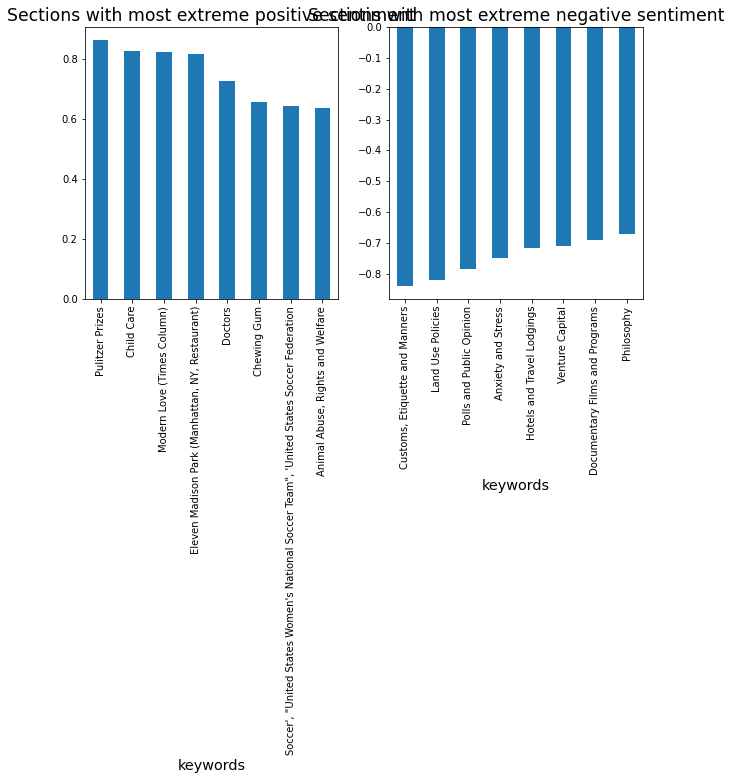

In [0]:
extreme_sentiments(8, 'keywords')

Extreme sentiment according to the section name of the article.

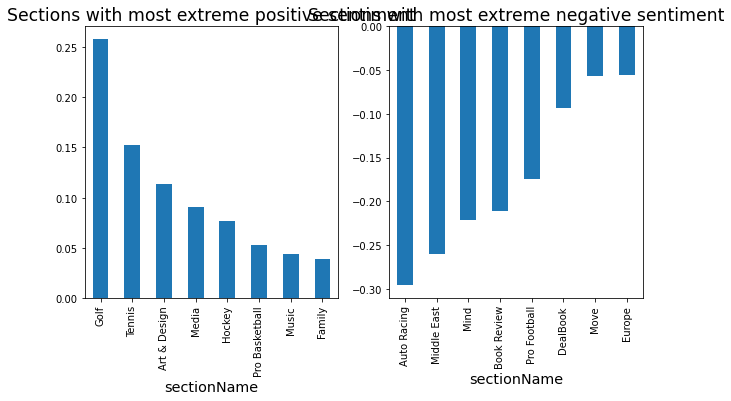

In [0]:
extreme_sentiments(8, 'sectionName')

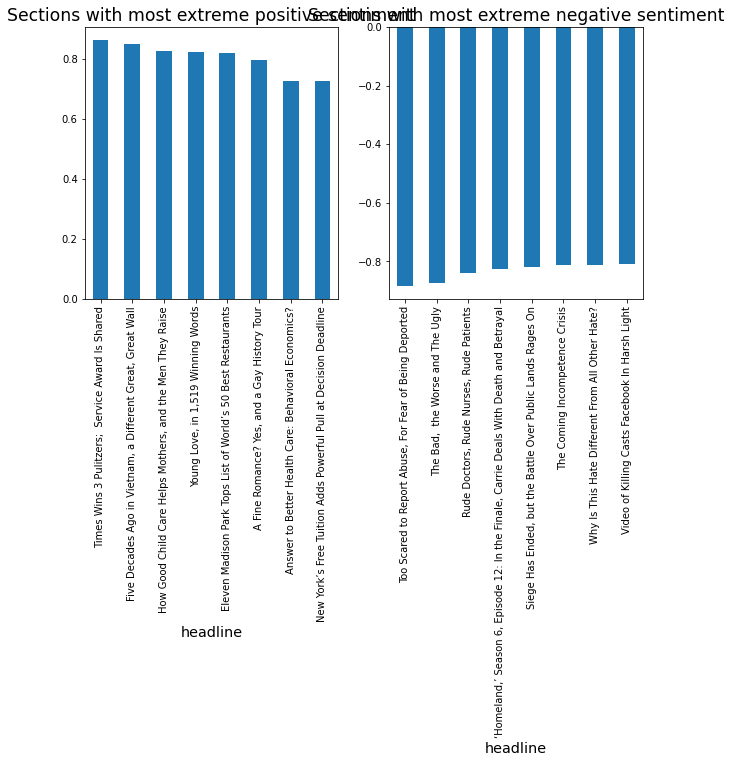

In [0]:
extreme_sentiments(8, 'headline')

**Remark:** sports seem to be overrepresented among articles associated with extreme sentiments.

### Political Sentiments

Let us first identify some political names available in the Keywords.

1. Trump, Donald J
2. Fillon, Francois
3. Le Pen, Marine
4. Putin, Vladimir V
5. Melenchon, Jean-Luc
6. Merkel, Angela
7. Obama, Barack
8. Maduro, Nicolas


In [0]:
def comparaison_sentiment_political(d):
  a = pd.DataFrame(d, index = ['Sentiment Score', 'Number of articles'])
  return a

The following piece of code performs sentiment analysis for these political names. 

In [0]:
l = ['Trump, Donald J', 'Fillon, Francois', 'Le Pen, Marine',\
     'Putin, Vladimir V', 'Melenchon, Jean-Luc', 'Merkel, Angela',\
     'Obama, Barack', 'Maduro, Nicolas']
d = {}

for elem in l:
  res = []
  for i in range(len(articles)):
    if articles.keywords[i] == elem:
      res.append(articles.sentiment[i])
  d[elem] = round(np.mean(res),2)

comparaison_sentiment_political(d)


,"Trump, Donald J","Fillon, Francois","Le Pen, Marine","Putin, Vladimir V","Melenchon, Jean-Luc","Merkel, Angela","Obama, Barack","Maduro, Nicolas"
Sentiment Score,-0.04,-0.16,0.02,0.02,-0.01,0.0,-0.17,0.0
Number of articles,-0.04,-0.16,0.02,0.02,-0.01,0.0,-0.17,0.0


Hence:
1. Trump, Fillon and Obame are associated with negative sentiments among NYT articles. 
2. The other names are quite neutral

## 2.3. Comments database

### Number of comments: Top Keywords vs Overall sample

In [0]:
# An operation to merge the two databases on the article ID.
grouped_comments = comments.groupby('articleID').count().reset_index()[['articleID', 'commentBody']]
articles = pd.merge(articles, grouped_comments.rename(columns={'commentBody': 'commentCount'}), on='articleID', how='inner').sort_values('commentCount', ascending=False)
articles.drop_duplicates(['headline', 'keywords'], inplace=True)

In [0]:
print("Overall average number of comments: {}".format(round(articles.drop_duplicates('headline')['commentCount'].mean(),2)), end='\n\n')
for kw in top_5_keywords:
    kw_match = articles[articles['keywords'] == kw].drop_duplicates('headline')
    print("Average number of comments for {}: {}".format(kw, round(kw_match['commentCount'].mean(),2)))
    

Overall average number of comments: 292.53

Average number of comments for United States Politics and Government: 654.18
Average number of comments for Trump, Donald J: 631.93
Average number of comments for United States International Relations: 612.1
Average number of comments for Crossword Puzzles: 63.46
Average number of comments for Television: 201.32


There is a significant difference, for each case. In particular:

1. 'United States Politics and Government', 'Trump', 'United States International Relations and' articles are more likely to generate much more comments than the average on the overall sample.
2. 'Television' and 'Crossword Puzzles' are less likely to generate a lot of comments that the average of the overall sample.

### Number of comments and sentiment score

Let us produce a graph showing the relationship between the sentiment score and the commentCount variable (characterizing the number of comments).

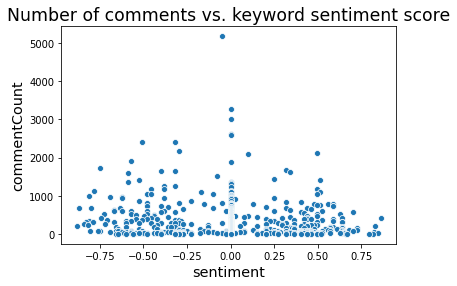

In [0]:
sns.scatterplot(x = 'sentiment', y = 'commentCount', data = articles.drop_duplicates('headline'))
plt.title('Number of comments vs. keyword sentiment score')
plt.show()

### Number of comments and Keywords

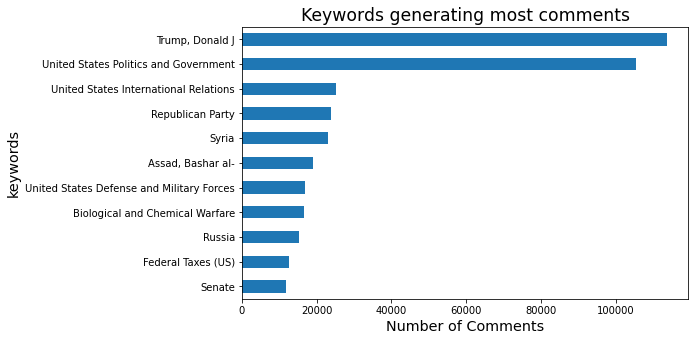

In [0]:
articles.groupby('keywords')['commentCount'].sum().sort_values(ascending=False).iloc[10::-1].plot.barh(figsize=(8, 5))
plt.xlabel('Number of Comments')
plt.title('Keywords generating most comments')
plt.show()

Always political topics!

### Most commented on articles

In [0]:
a = articles.sort_values('commentCount', ascending=False).drop_duplicates('headline')[['headline', 'commentCount', 'sentiment']].iloc[:10].reset_index()
a

,index,headline,commentCount,sentiment
0,1190,"Man Is Dragged From a Full Jet, Stirring a Furor",5181,-0.0516
1,759,U.S. Launches Missiles Into Syria,3263,0.0000
2,2790,The Cost of a Speech,3005,0.0000
3,3600,"Fox News Ousts O’Reilly, A Host Central to Its...",2618,0.0000
4,678,Republicans Gut Filibuster Rule to Lift Gorsuch,2593,0.0000
5,1365,Dragging of Passenger Sets Off a Crisis at United,2408,-0.3182
6,641,"How I Angered My Readers, Again",2397,-0.5106
7,3955,"In Trying to Avoid Politics, Comey Shaped an E...",2169,-0.2960
8,2153,Tax Overhaul Would Aid Wealthiest,2132,0.4939
9,1391,Inaccurate Hitler Comment Leads Spicer to Apol...,2104,0.1027


Identifying mean sentiment score for most commented on articles.

In [0]:
print('Mean sentiment score for most commented on articles:',round(np.mean(a.sentiment),2))

Mean sentiment score for most commented on articles: -0.06


### Analyzing comments themselves

In [0]:
comments.head()

,commentBody,editorsSelection,permID,recommendations,articleID,sectionName,reco_categ2,comment_type,length,n_words,reco_categ3
0,this project makes me happy to be a 30 year ti...,0,22022598,2.0,58def1347c459f24986d7c80,Unknown,1,1,115,18,0
1,stunning photos and reportage infuriating that...,0,22017350,1.0,58def1347c459f24986d7c80,Unknown,1,1,233,32,0
2,brilliant work from conception to execution iv...,0,22017334,3.0,58def1347c459f24986d7c80,Unknown,1,1,533,93,0
3,nyt reporters should provide a contributors li...,0,22015913,7.0,58def1347c459f24986d7c80,Unknown,1,1,441,70,1
4,could only have been done in print stunning,0,22015466,5.0,58def1347c459f24986d7c80,Unknown,1,1,46,8,1


In [0]:
# Computationnaly intensive to be run !
comments = comments.assign(sentiment=comments['commentBody'].apply(sentiment_score))

In [0]:
sample_mean = np.round(comments['sentiment'].mean(), 4)
sample_mean_error = np.round(sem(comments['sentiment']), 4)
print("Overall average comment sentiment: {} +/- {}".format(sample_mean, sample_mean_error, 4))

Overall average comment sentiment: 0.0429 +/- 0.0012


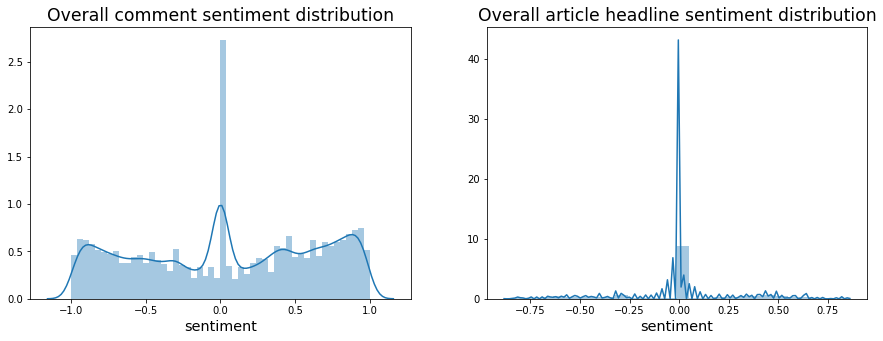

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flat
sns.distplot(comments.drop_duplicates('commentBody')['sentiment'], ax = axes[0])
sns.distplot(articles.drop_duplicates('headline')['sentiment'], ax = axes[1])
axes[0].set_title('Overall comment sentiment distribution')
axes[1].set_title('Overall article headline sentiment distribution')
plt.show()

A non-surprising pattern is appearing: articles produce neutral sentiment and comments concentrate extreme sentiment scores.

## 2.4. Answering questions

1. In average, is the sentiment score equal for articles and comments ? There is a huge polarization for comments sentiment scores (a lot of extreme sentiments) which is not the case for articles.
2. Which are articles headlines producing extreme sentiments (best and worst) ? Sports, music and media produce extreme sentiments.
3. Among the top Keywords (most frequent keywords) articles, what is the sentiment score distribution ? The sentiment is neutral for the most frequent top Keywords (meaning that most frequent keywords are objective informations, not very likely to be interpreted).
4. Which themes produce extreme sentiments ? Sports, music and media produce extreme sentiments.
5. Do top Keywords generate in average the same number of sentiments ? Top Keywords (i.e. Keywords which produce a lot of articles produce, in average, more comments than the average).
6. What are Headlines generating the most commments and their associated sentiment score ? Headlines generating the highest number of comments are available in the 'most commented on articles' section. Their sentiment score is -0.06 in average.

#3.Predicting a topic 

**Based on a comment, guessing the topic (using sectionName or newDesk as the target variable) of the article.**

##3.1. Database exploration and statistics

### Number of different topics for each target variables

In [0]:
data = com_ap_17[0:20000]

**Overview of the classification topic using sectionName** 

In [0]:
print("There are {0} different topics for sectionName.".format(len(data.groupby("sectionName"))))

There are 14 different topics for sectionName.


In [0]:
data.groupby("sectionName").apply(len)

sectionName
Asia Pacific           391
Baseball               139
College Basketball     431
Education Life         346
Family                 196
Hockey                  90
Lesson Plans             1
Live                   592
Media                 1348
Politics              2479
Pro Basketball          26
Sunday Review         3915
Television             512
Unknown               9534
dtype: int64

**Remarks**: there are 9534 observations in your data set labelled at unknown.

**Overview of the classification topic using newDesk** 

In [0]:
print("There are {0} different topics for newDesk.".format(len(data.groupby("newDesk"))))

There are 19 different topics for newDesk.


In [0]:
data.groupby("newDesk").apply(len)

newDesk
Business      1348
Culture        637
Dining          57
EdLife         346
Editorial     1754
Foreign        391
Games          308
Insider         52
Learning       576
Metro           25
National      3333
OpEd          7580
RealEstate     111
Science        592
Sports         686
Travel         268
Unknown         10
Upshot        1730
Well           196
dtype: int64

**Remarks:** there are only 10 observations labelled at unknown.


### Some statistics


**Distribution of SectionName**

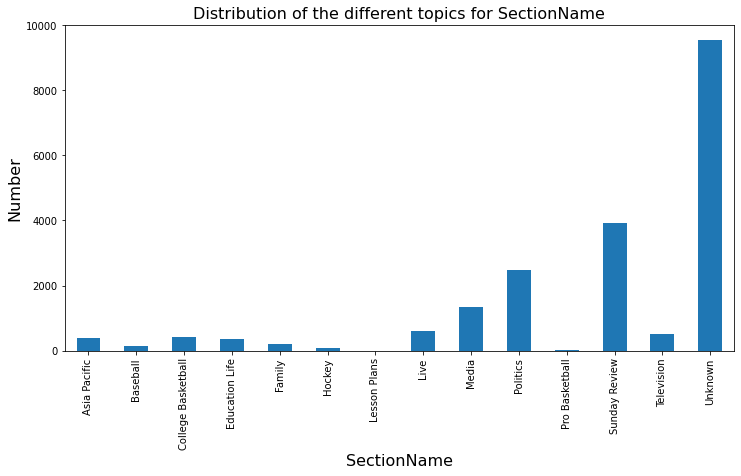

In [0]:
dep=data.groupby("sectionName").apply(len)
ax = dep.plot(kind = "bar", figsize=(12,6))
ax.set_xlabel("SectionName", fontsize=16)
ax.set_ylabel("Number", fontsize=16)
ax.set_title("Distribution of the different topics for SectionName", fontsize=16)
ax.legend().set_visible(False) 

Removing the value "Unknown" of the topics:

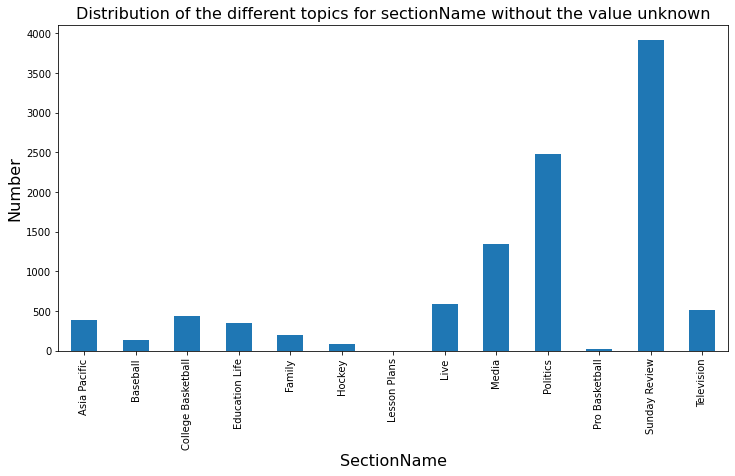

In [0]:
dep=data[data["sectionName"]!="Unknown"].groupby("sectionName").apply(len)
ax = dep.plot(kind = "bar", figsize=(12,6))
ax.set_xlabel("SectionName", fontsize=16)
ax.set_ylabel("Number", fontsize=16)
ax.set_title("Distribution of the different topics for sectionName without the value unknown", fontsize=16)
ax.legend().set_visible(False) 

**Distribution of newDesk**

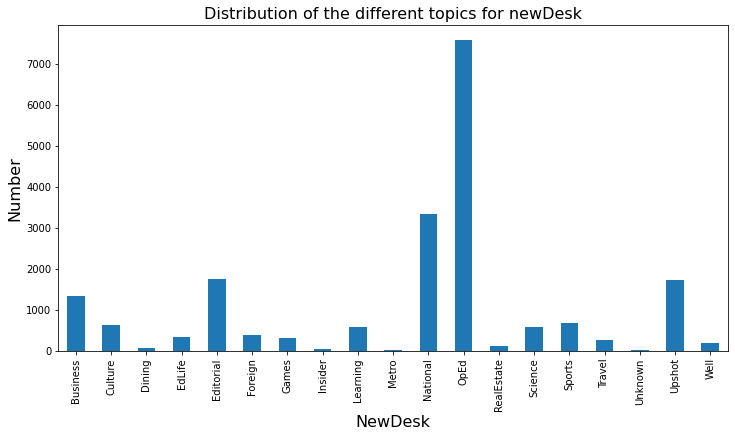

In [0]:
dep=data.groupby("newDesk").apply(len)
ax = dep.plot(kind = "bar", figsize=(12,6))
ax.set_xlabel("NewDesk", fontsize=16)
ax.set_ylabel("Number", fontsize=16)
ax.set_title("Distribution of the different topics for newDesk", fontsize=16)
ax.legend().set_visible(False) 

**Remarks:** OpEd is a recurring topic for NewDesk (nearly 7000 observations).

**Important: Since there are almost half of the observations that are labelled as unknown for the target variable sectionName, we will only do the prediction using the target variable NewDesk. We will first try to do prediction with all classes and after that we will tune the target variables.**

##3.2. Sequence labelling using Logistic regression

Our first model is a logistic regression. It was implemented by using classes. We ramdomly initiated the weight matrix. Then we calculate the output via the forward method, calculate the loss using the nll function and do the backwardation. 

### Define the model

In [0]:
class LogisticRegression():

    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size), low=-0.1, high=0.1)
        self.b = np.random.uniform(size=output_size, low=-0.1, high=0.1)
        self.output_size = output_size
        
    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)
    
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
    
    def grad_loss(self, x, y_true):
        y_pred = self.forward(x)
        dnll_output =  y_pred - one_hot(self.output_size, y_true)
        grad_W = np.outer(x, dnll_output)
        grad_b = dnll_output
        grads = {"W": grad_W, "b": grad_b}
        return grads
    
    def train(self, x, y, learning_rate):
        grads = self.grad_loss(x, y)
        self.W = self.W - learning_rate * grads["W"]
        self.b = self.b - learning_rate * grads["b"]      
        
    def loss(self, X, y):
        return nll(one_hot(self.output_size, y), self.forward(X))

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

`nll`: function that given the true one-hot encoded class Y_true and some predicted probabilities Y_pred returns the negative log likelihood.

In [0]:
EPSILON = 1e-8
def nll(Y_true, Y_pred):
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred)
    loglikelihoods = np.sum(np.log(EPSILON + Y_pred) * Y_true, axis=1)
    return -np.mean(loglikelihoods)

`softmax`: function that returns the result of a softmax function given an input X.

In [0]:
def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)

### Prepare the data

We have to one-hot encoding the  label and embedding the feature. We will only use 10,000 observations.

In [0]:
X=data["commentBody"][0:10000]
y=data["newDesk"][0:10000]


#### Preprocessing class label data


We define a function which returns a dictionary with all the name of the different labels and their index  (label_index) and a list that indexes the value of y (`y_to_index`).

In [0]:
def label_to_idx(y):
  label_index={}
  y_to_index=[]
  counter=0
  for y1 in y:
    if y1 not in label_index:
      label_index[y1]=counter
      counter+=1
    y_to_index.append(label_index[y1])

  return label_index, y_to_index

In [0]:
dico_index,y_to_index=label_to_idx(y)
nb_labelling=len(dico_index)

In [0]:
print(style.BOLD + '---- Before indexation ----' + style.END)
print(y[0])
print(style.BOLD + '---- After indexation ----' + style.END)
print(y_to_index[0])
print(style.BOLD + '---- Number of classes in the sample ----' + style.END)
print(nb_labelling)

---- Before indexation ----
Insider
---- After indexation ----
0
---- Number of classes in the sample ----
12


In [0]:
print("Differents labels and their index: {0}".format(dico_index))

Differents labels and their index: {'Insider': 0, 'OpEd': 1, 'Editorial': 2, 'Sports': 3, 'Games': 4, 'Culture': 5, 'Travel': 6, 'Business': 7, 'RealEstate': 8, 'National': 9, 'Metro': 10, 'Learning': 11}


We define a helper function to compute the one hot encoding of an integer array for a fixed number of classes:

In [0]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [0]:
print(style.BOLD + '---- Before one hot encoding ----' + style.END)
print(2)
print(style.BOLD + '---- After one hot encoding ----' + style.END)
print(one_hot(4,2))

---- Before one hot encoding ----
2
---- After one hot encoding ----
[0. 0. 1. 0.]


In [0]:
y_label_oh=one_hot(n_classes=nb_labelling, y=y_to_index)

In [0]:
print(style.BOLD + '---- Before one hot encoding ----' + style.END)
print(y_to_index[0])
print(style.BOLD + '---- After one hot encoding ----' + style.END)
print(y_label_oh[0])
print(style.BOLD + '---- Shape of the target variable ----' + style.END)
print(y_label_oh.shape)

---- Before one hot encoding ----
0
---- After one hot encoding ----
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
---- Shape of the target variable ----
(10000, 12)


#### Preprocessing the feature using Word2vec

In [0]:
X_train=X[0:7000]
X_test=X[7000:]
y_train=y_to_index[0:7000]
y_test=y_to_index[7000:]

In [0]:
X_train_w,X_test_w=w2v(X_train,X_test)
X_train=np.asarray(X_train_w)
X_test=np.asarray(X_test_w)

100%|██████████| 7000/7000 [00:02<00:00, 2784.27it/s]


### Training the model

We build an untrained model and test its forward inference:

In [0]:
n_features = X_train.shape[1]
n_classes = nb_labelling
lr = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f" % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 2.5197, train acc: 0.033, test acc: 0.027


**We train the model using 10 epochs and a learning rate of 0.01:**

In [0]:
learning_rate = 0.01
N_epochs = 10

for epoch in range(N_epochs):
    print('--- Epoch', epoch+1, '/', N_epochs ,'---')
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        lr.train(x, y, learning_rate)
        if i % 300 == 0:
            train_loss = lr.loss(X_train, y_train)
            train_acc = lr.accuracy(X_train, y_train)
            test_acc = lr.accuracy(X_test, y_test)
            print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
                  % (i, train_loss, train_acc, test_acc))

**As the result for the last update of the logistic regression is not very convincing (test accuracy: 0.354), we will build a deeper neural network with one hidden layer.**

##3.3. Sequence labelling using a feedforward multilayer

We are implementing the backpropagation algorithm  on a single layer neural network using the sigmoid activation function.


### Define the model

In [0]:
class NeuralNet():

    def __init__(self, input_size, hidden_size, output_size):
        self.W_h = np.random.uniform(size=(input_size, hidden_size), low=-0.01, high=0.01)
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(size=(hidden_size, output_size), low=-0.01, high=0.01)
        self.b_o = np.zeros(output_size)
        self.output_size = output_size

    def forward(self, X, keep_activations=False):
        z_h = np.dot(X, self.W_h) + self.b_h
        h   = sigmoid(z_h)
        z_o = np.dot(h, self.W_o) + self.b_o
        y   = softmax(z_o)
        if keep_activations:
            return y, h, z_h
        else:
            return y

    def loss(self, X, y):
        return nll(one_hot(self.output_size, y), self.forward(X))

    def grad_loss(self, x, y_true):
        y, h, z_h = self.forward(x, keep_activations=True)
        
        grad_z_o = y - one_hot(self.output_size, y_true)
        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o
        
        grad_h   = np.dot(grad_z_o, np.transpose(self.W_o))
        grad_z_h = grad_h * dsigmoid(z_h)
        grad_W_h = np.outer(x, grad_z_h)
        grad_b_h = grad_z_h
        
        grads    = {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}
        return grads

    def train(self, x, y, learning_rate):
        grads = self.grad_loss(x, y)
        self.W_h = self.W_h - learning_rate * grads["W_h"]
        self.b_h = self.b_h - learning_rate * grads["b_h"]
        self.W_o = self.W_o - learning_rate * grads["W_o"]
        self.b_o = self.b_o - learning_rate * grads["b_o"]

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)


`sigmoid`: function that returns the result of a sigmoid function given an input X.

In [0]:
def sigmoid(X):
    return 1 / (1 + np.exp(-X))

`dsigmoid`: function that returns the derivative of the sigmoid givent an input X.

In [0]:
def dsigmoid(X):
    sig = sigmoid(X)
    return sig * (1 - sig)

### Training the model

We build an untrained model and test its forward inference:

In [0]:
n_hidden = 30
model = NeuralNet(n_features, n_hidden, n_classes)

print("Evaluation of the untrained model:")
train_loss = model.loss(X_train, y_train)
train_acc = model.accuracy(X_train, y_train)
test_acc = model.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f" % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 2.4958, train acc: 0.038, test acc: 0.000


**We train the model using 10 epochs and a learning rate of 0.01:**

In [0]:
N_epochs = 10

losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(N_epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 2.49584, train acc: 0.038, test acc: 0.000
Epoch #1, train loss: 5.14544, train acc: 0.432, test acc: 0.354
Epoch #2, train loss: 5.05831, train acc: 0.432, test acc: 0.354
Epoch #3, train loss: 4.98206, train acc: 0.432, test acc: 0.354
Epoch #4, train loss: 4.91210, train acc: 0.432, test acc: 0.354
Epoch #5, train loss: 4.84541, train acc: 0.432, test acc: 0.354
Epoch #6, train loss: 4.77999, train acc: 0.432, test acc: 0.354
Epoch #7, train loss: 4.71452, train acc: 0.432, test acc: 0.354
Epoch #8, train loss: 4.64916, train acc: 0.432, test acc: 0.354
Epoch #9, train loss: 4.58615, train acc: 0.432, test acc: 0.354
Epoch #10, train loss: 4.53166, train acc: 0.432, test acc: 0.354


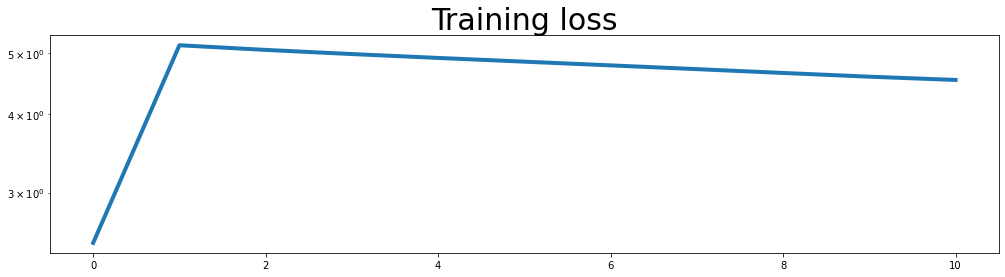

In [0]:
plt.figure(figsize=(17,4))
plt.semilogy(losses, lw=4)
plt.title("Training loss", fontsize=30)
plt.show()

**The result for the feedforward multilayer is no better than the logistic regression.**

##3.4. Sequence labelling using Random Forest

As the two last results were not convincing, we will try to use a Random Forest model to predict the different labels. 

### Implementing and training the model

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

rfc = OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=None, \
                                                 criterion = 'entropy',random_state=42, n_jobs=-1, verbose=1))

rfc.fit(X_train, y_train)
y_test_pred = rfc.predict(X_test)

### Evaluation

`evaluation_multiclass`: function which returns the accuracy of a prediction multiclass.

In [0]:
def evaluation_multiclass(y,y_pred):
  # Accuracy
  somme = 0
  for i in range(len(y)):
    if y[i] == y_pred[i]:
      somme += 1
  print(style.BOLD + 'Accuracy:' + style.END, round(somme/len(y),2))
  return round(somme/len(y),2)

In [0]:
evaluation_multiclass(y_test,y_test_pred)

Accuracy: 0.32


0.32

**Random Forest returns an accuracy of 0.32. The model is no better than the others.**

##3.5. Sequence labelling tuning the target variable

**As we showed earlier, results from trying to predict all the labels are not convincing. We are going to tune the target variable and remove some classes to improve our results.**

### Removing labelling classes

We are going to delete the labels with the lowest frequency.

`data_label_remove`: deletes the observations which are labelled with the `nb_remove` least present labels.

In [0]:
def data_label_remove(df,nb_remove,champ):

  df2=df.groupby(champ).apply(len).sort_values()

  for i in range(nb_remove):
    remove=df2.index[i]
    df=df[df[champ]!=remove]

  return df

**First we are only going to use four classes.**

In [0]:
nb_remove=14
df=data_label_remove(data[0:15000],nb_remove,"newDesk")

In [0]:
print(style.BOLD + '---- Before cleaning ----' + style.END)
print(data[0:15000].groupby("newDesk").apply(len).sort_values())
print(style.BOLD + '---- After cleaning ----' + style.END)
print(df.groupby("newDesk").apply(len).sort_values())
print(style.BOLD + '---- Number of classes ----' + style.END)
print(len(df.groupby("newDesk")))

---- Before cleaning ----
newDesk
Unknown         10
Metro           17
Insider         52
Upshot          88
RealEstate     111
Well           196
Games          254
Travel         268
EdLife         346
Foreign        391
Sports         514
Learning       557
Culture        584
Science        592
Editorial     1166
Business      1348
National      1819
OpEd          6687
dtype: int64
---- After cleaning ----
newDesk
Editorial    1166
Business     1348
National     1819
OpEd         6687
dtype: int64
---- Number of classes ----
4


### Preprocessing

In [0]:
X=df["commentBody"][0:10000]
y=df["newDesk"][0:10000]

**Preprocessing class labels data**

In [0]:
dico_index,y_to_index=label_to_idx(y)
nb_labelling=len(dico_index)

**Training and test sets**

In [0]:
X_train=X[0:7000]
X_test=X[7000:]
y_train=y_to_index[0:7000]
y_test=y_to_index[7000:]

**Preprocessing the feature using Word2vec**

In [0]:
X_train_w,X_test_w=w2v(X_train,X_test)
X_train=np.asarray(X_train_w)
X_test=np.asarray(X_test_w)

100%|██████████| 7000/7000 [00:02<00:00, 2768.44it/s]


### Predicting using a logistic regression

Build an untrained model and test its forward inference:

In [0]:
n_features = X_train.shape[1]
n_classes = nb_labelling
lr = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f" % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 1.3553, train acc: 0.422, test acc: 0.602


**We train the model using 10 epochs and a learning rate of 0.01:**

In [0]:
learning_rate = 0.01
N_epochs = 10

for epoch in range(N_epochs):
    print('--- Epoch', epoch+1, '/', N_epochs ,'---')
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        lr.train(x, y, learning_rate)
        if i % 1000 == 0:
            train_loss = lr.loss(X_train, y_train)
            train_acc = lr.accuracy(X_train, y_train)
            test_acc = lr.accuracy(X_test, y_test)
            print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
                  % (i, train_loss, train_acc, test_acc))

**Test accuracy for the last update of the last epoch is 0.839 and it is much better than the results we obtain when we tried to predict all the classes.**

### Predicting using a feedforward multilayer

Build an untrained model and test its forward inference:

In [0]:
n_hidden = 30
model = NeuralNet(n_features, n_hidden, n_classes)

print("Evaluation of the untrained model:")
train_loss = model.loss(X_train, y_train)
train_acc = model.accuracy(X_train, y_train)
test_acc = model.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f" % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 1.3815, train acc: 0.543, test acc: 0.841


**We train the model using 30 epochs and a learning rate of 0.01:**

In [0]:
N_epochs = 30

losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(N_epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

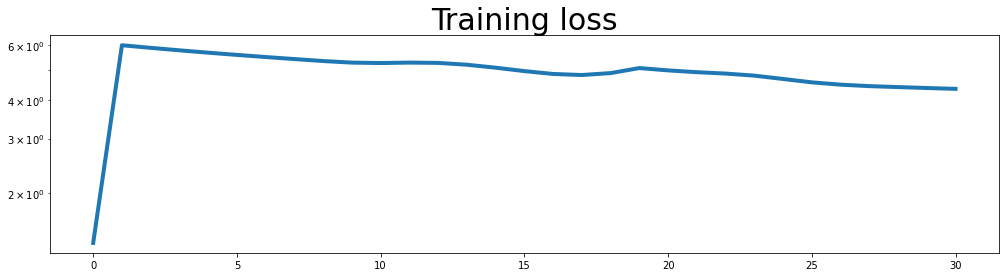

In [0]:
plt.figure(figsize=(17,4))
plt.semilogy(losses, lw=4)
plt.title("Training loss", fontsize=30)
plt.show()

**The loss decreases but the accuracy remains low.**

### Predicting using Random forest

We use `GridSearchCV` to optimize the hyper parameters.

In [0]:
X_w = np.concatenate((X_train, X_test))

In [0]:
from sklearn.model_selection import GridSearchCV  
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1)
parameters = {'n_estimators': [100,200,300,400,500],'criterion' :['gini', 'entropy']}

#ALREADY DONE: DO NOT LAUNCH AGAIN
#clf = GridSearchCV(rfc, parameters, cv= 3)
#clf.fit(X_w, y_label)

In [0]:
clf.best_params_

`GridSearchCV` give us that the best hyper parameters are: `{'criterion': 'entropy', 'n_estimators': 200}`

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

rfc = OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=None, \
                                                 criterion = 'entropy',random_state=42, n_jobs=-1, verbose=1))

rfc.fit(X_train, y_train)
y_test_pred = rfc.predict(X_test)

**Evaluation**

In [0]:
evaluation_multiclass(y_test,y_test_pred)

Accuracy: 0.8


`c_matrix`: returns a dataframe with the confusion matrix (reality:column, prevision: index).

In [0]:
from sklearn.metrics import confusion_matrix

def c_matrix(y,y_pred,dico_c):

  l_key=[]
  for key in dico_c:
    l_key.append(key)

  cm=confusion_matrix(y_test, y_test_pred)
  df=pd.DataFrame(cm.transpose(),index=l_key,
                  columns=l_key)

  return df 

In [0]:
c_matrix(y_test, y_test_pred,dico_index)

,OpEd,Editorial,Business,National
OpEd,2388,156,0,293
Editorial,61,4,0,11
Business,22,0,0,6
National,51,0,0,8


**We obtain an accuracy of 0.8 for the label prediction using the random forest model**.

### Sequence Labelling using Logistic Regression from scikit learn

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

clr = OneVsRestClassifier(LogisticRegression(max_iter=200))
clr.fit(X_train, y_train)
y_test_pred = clr.predict(X_test)

In [0]:
evaluation_multiclass(y_test,y_test_pred)

Accuracy: 0.77


In [0]:
c_matrix(y_test, y_test_pred,dico_index)

,OpEd,Editorial,Business,National
OpEd,2303,153,0,263
Editorial,69,1,0,24
Business,81,4,0,19
National,69,2,0,12


**We obtain an accuracy of 0.77.**

### Sequence Labelling using SVM

We use `GridSearchCV` to optimize the hyper parameters.

In [0]:
from sklearn.model_selection import GridSearchCV  
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

parameters = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
slr = OneVsRestClassifier(SVC())

#ALREADY DONE: DO NOT LAUNCH AGAIN
#slf = GridSearchCV(SVC(), parameters, cv= 3)
#slf.fit(X_w, y_label)


In [0]:
slf.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

`GridSearchCV` give us that the best hyper parameters are: `{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}`

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

slr = OneVsRestClassifier(SVC(C=100, gamma= 0.01, kernel= 'rbf'))
slr.fit(X_train, y_train)
y_test_pred = clr.predict(X_test)

In [0]:
evaluation_multiclass(y_test,y_test_pred)

Accuracy: 0.77


In [0]:
c_matrix(y_test, y_test_pred,dico_index)

,OpEd,Editorial,Business,National
OpEd,2303,153,0,263
Editorial,69,1,0,24
Business,81,4,0,19
National,69,2,0,12


**We obtain an accuracy of 0.77.**

**The results are much better when we are decreasing the number of classes.**

### Determine how many classes to remove to get the best predictions

As seen previously the results are better when we remove the less frequent classes. We want to know how many classes we have to remove to obtain the best predictions. We will use random forest classifier and svm.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
rf=[]
sv=[]
for i in range(0,17):
  nb_remove=i
  df_=data_label_remove(data[0:15000],nb_remove,"newDesk")
  X=df_["commentBody"][0:10000]
  y=df_["newDesk"][0:10000]

  dico_index,y_to_index=label_to_idx(y)
  nb_labelling=len(dico_index)

  X_train=X[0:7000]
  X_test=X[7000:]
  y_train=y_to_index[0:7000]
  y_test=y_to_index[7000:]
  X_train_w,X_test_w=w2v(X_train,X_test)
  X_train=np.asarray(X_train_w)
  X_test=np.asarray(X_test_w)

  rfc = OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=None, \
                                                 criterion = 'entropy',random_state=42, n_jobs=-1, verbose=1))

  rfc.fit(X_train, y_train)
  y_test_pred = rfc.predict(X_test)
  rf.append([i,evaluation_multiclass(y_test,y_test_pred)])

  slr = OneVsRestClassifier(SVC(C=100, gamma= 0.01, kernel= 'rbf'))
  slr.fit(X_train, y_train)
  y_test_pred = slr.predict(X_test)
  sv.append([i,evaluation_multiclass(y_test,y_test_pred)])


In [0]:
l_results=[]
for i in range(0,17):
  l_results.append([rf[i][1],sv[i][1]])
df_results=pd.DataFrame(l_results,index=["18 classes", "17 classes", "16 classes",
                                  "15 classes","14 classes", "13 classes",
                                  "12 classes","11 classes","10 classes",
                                  "9 classes","8 classes",
                                  "7 classes","6 classes", "5 classes"
                               ,"4 classes","3 classes","2 classes"]\
                        , columns=["Random Forest", "SVM"])


In [0]:
df_results

,Random Forest,SVM
18 classes,0.32,0.28
17 classes,0.31,0.29
16 classes,0.32,0.29
15 classes,0.31,0.28
14 classes,0.32,0.28
13 classes,0.31,0.28
12 classes,0.30,0.27
11 classes,0.35,0.30
10 classes,0.35,0.32
9 classes,0.35,0.32


**Conclusion:** Predictions start to be good from 6 classes upwards. They become weak again for 2 classes.

#4.Nature of a comment

**Predicting the nature of a comment (a comment or a user reply) using the commentType variable.**

##4.1. Database exploration and statistics

In [0]:
data = com_ap_17[0:20000]

**Overview of the commentType variable** 

In [0]:
data.groupby("commentType").apply(len)

commentType
comment          13868
reporterReply        4
userReply         6128
dtype: int64

**Remark:** As the number of observations for reporterReply is too small, we will only keep observations labelled as `comment` and `userReply`.

In [0]:
data = data[data["commentType"]!="reporterReply"]

In [0]:
data.groupby("commentType").apply(len)

In [0]:
dep=data.groupby("commentType").apply(len)
ax = dep.plot(kind = "bar", figsize=(12,6))
ax.set_xlabel("CommentType", fontsize=16)
ax.set_ylabel("Number", fontsize=16)
ax.set_title("Distribution of commentType", fontsize=16)
ax.legend().set_visible(False) 

##4.2. Prepare the data

We have to one-hot encoding the  label and embedding the feature. We will only use 10,000 observations.

In [0]:
X=data["commentBody"][9996:]
y=data["commentType"][9996:]

X=X.reset_index()
X=X.drop(["index"],axis='columns')["commentBody"]
y=y.reset_index()
y=y.drop(["index"],axis='columns')["commentType"]


#### Preprocessing class label data


In [0]:
dico_index,y_to_index=label_to_idx(y)
nb_labelling=len(dico_index)

In [0]:
print(style.BOLD + '---- Before indexation ----' + style.END)
print(y[0])
print(style.BOLD + '---- After indexation ----' + style.END)
print(y_to_index[0])
print(style.BOLD + '---- Number of classes in the sample ----' + style.END)
print(nb_labelling)

---- Before indexation ----
comment
---- After indexation ----
0
---- Number of classes in the sample ----
2


In [0]:
print("Differents labels and their index: {0}".format(dico_index))

Differents labels and their index: {'comment': 0, 'userReply': 1}


In [0]:
y_label_oh=one_hot(n_classes=nb_labelling, y=y_to_index)

In [0]:
print(style.BOLD + '---- Before one hot encoding ----' + style.END)
print(y_to_index[0])
print(style.BOLD + '---- After one hot encoding ----' + style.END)
print(y_label_oh[0])
print(style.BOLD + '---- Shape of the target variable ----' + style.END)
print(y_label_oh.shape)

---- Before one hot encoding ----
0
---- After one hot encoding ----
[1. 0.]
---- Shape of the target variable ----
(10004, 2)


#### Preprocessing the feature using Word2vec

In [0]:
X_train=X[0:7000]
X_test=X[7000:]
y_train=y_to_index[0:7000]
y_test=y_to_index[7000:]

In [0]:
X_train_w,X_test_w=w2v(X_train,X_test)
X_train=np.asarray(X_train_w)
X_test=np.asarray(X_test_w)

100%|██████████| 7000/7000 [00:02<00:00, 2611.32it/s]


##4.3. Sequence labelling using Logistic regression

We are going to use the logistic regression model we created for the third problem.

**Training the model**

We build an untrained model and test its forward inference:

In [0]:
n_features = X_train.shape[1]
n_classes = nb_labelling
lr = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f" % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 0.6874, train acc: 0.552, test acc: 0.575


**We train the model using 10 epochs and a learning rate of 0.01:**

In [0]:
learning_rate = 0.01
N_epochs = 10

losses, accuracies, accuracies_test = [], [], []
losses.append(lr.loss(X_train, y_train))

for epoch in range(N_epochs):
    print('--- Epoch', epoch+1, '/', N_epochs ,'---')
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        lr.train(x, y, learning_rate)

    losses.append(lr.loss(X_train, y_train))
    accuracies.append(lr.accuracy(X_train, y_train))
    accuracies_test.append(lr.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))
    

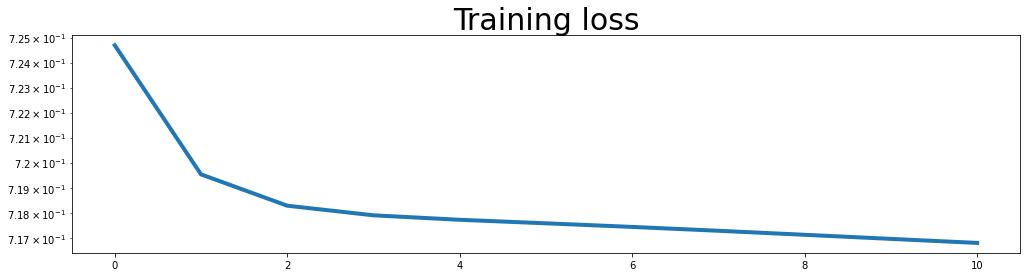

In [0]:
plt.figure(figsize=(17,4))
plt.semilogy(losses, lw=4)
plt.title("Training loss", fontsize=30)
plt.show()

**For the ten epoch, we obtain a train loss of 0.72, a train accuracy of 0.73 and a test accuracy of 0.71.**

##4.4. Sequence labelling using a feedforward multilayer

We are going to use the feedforward multilayer model we created for the third problem.

**Training the model**

We build an untrained model and test its forward inference:

In [0]:
n_hidden = 30
model = NeuralNet(n_features, n_hidden, n_classes)

print("Evaluation of the untrained model:")
train_loss = model.loss(X_train, y_train)
train_acc = model.accuracy(X_train, y_train)
test_acc = model.accuracy(X_test, y_test)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f" % (train_loss, train_acc, test_acc))

Evaluation of the untrained model:
train loss: 0.6844, train acc: 0.725, test acc: 0.708


**We train the model using 10 epochs and a learning rate of 0.01:**

In [0]:
N_epochs = 10

losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(N_epochs):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

Random init: train loss: 0.68439, train acc: 0.725, test acc: 0.708
Epoch #1, train loss: 1.53075, train acc: 0.725, test acc: 0.708
Epoch #2, train loss: 1.44100, train acc: 0.725, test acc: 0.708
Epoch #3, train loss: 1.36782, train acc: 0.725, test acc: 0.708
Epoch #4, train loss: 1.31152, train acc: 0.725, test acc: 0.708
Epoch #5, train loss: 1.26783, train acc: 0.725, test acc: 0.708
Epoch #6, train loss: 1.23381, train acc: 0.725, test acc: 0.708
Epoch #7, train loss: 1.20869, train acc: 0.725, test acc: 0.708
Epoch #8, train loss: 1.19298, train acc: 0.725, test acc: 0.708
Epoch #9, train loss: 1.18494, train acc: 0.725, test acc: 0.708
Epoch #10, train loss: 1.17837, train acc: 0.725, test acc: 0.708


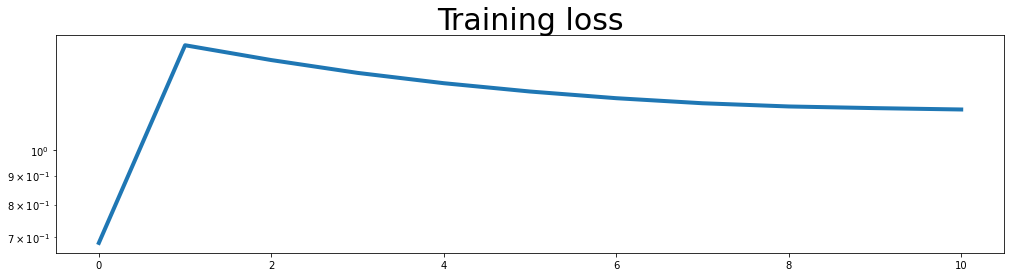

In [0]:
plt.figure(figsize=(17,4))
plt.semilogy(losses, lw=4)
plt.title("Training loss", fontsize=30)
plt.show()

**For the ten epoch, we obtain a train loss of 1.18, a train accuracy of 0.725 and a test accuracy of 0.71. It is no better than the logistic regression. Which proves that adding more complexity and layers does not necessarily improve the model.**

##4.5. Sequence labelling using Random Forest

We use `GridSearchCV` to optimize the hyper parameters.

In [0]:
X_w = np.concatenate((X_train, X_test))
y_label=np.concatenate((y_train, y_test))

In [0]:
from sklearn.model_selection import GridSearchCV  
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_jobs=-1)
parameters = {'n_estimators': [100,200,300,400,500],'criterion' :['gini', 'entropy']}

#ALREADY DONE: DO NOT LAUNCH AGAIN
#clf = GridSearchCV(rfc, parameters, cv= 3)
#clf.fit(X_w, y_label)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_

In [0]:
#clf.best_params_

{'criterion': 'entropy', 'n_estimators': 500}

`GridSearchCV` give us that the best hyper parameters are: `{'criterion': 'entropy', 'n_estimators': 500}`

**Implementing and training the model**

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf4 = RandomForestClassifier(n_estimators=500, max_depth=None, \
                                                 criterion = 'entropy',random_state=42, n_jobs=-1, verbose=1)

rf4.fit(X_train, y_train)
y_test_pred = rf4.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   54.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.3s finished


**Evaluation**

In [0]:
evaluation(y_test,y_test_pred)

Accuracy: 0.73
F1 Score: 0.54
Recall: 0.56
Precision: 0.73
--------


(0.73, 0.54, 0.56, 0.73)

In [0]:
c_matrix(y_test, y_test_pred,dico_index)

,comment,userReply
comment,2077,748
userReply,47,128


**We find an accuracy of 0.73 for the Random Forest.**

##4.6. Sequence Labelling using Logistic Regression from scikit learn

**Implementing and training the model**

In [0]:
from sklearn.linear_model import LogisticRegression

lr4 = LogisticRegression(max_iter=200)
lr4.fit(X_train, y_train)
y_test_pred = lr4.predict(X_test)

**Evaluation**

In [0]:
evaluation(y_test,y_test_pred)

Accuracy: 0.73
F1 Score: 0.54
Recall: 0.56
Precision: 0.74
--------


(0.73, 0.54, 0.56, 0.74)

In [0]:
c_matrix(y_test, y_test_pred,dico_index)

,comment,userReply
comment,1906,669
userReply,220,205


**We obtain an accuracy of 0.73 for the Logistic Regression.**

##4.7. Sequence Labelling using SVM

We use `GridSearchCV` to optimize the hyper parameters.

In [0]:
from sklearn.model_selection import GridSearchCV  
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

parameters = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
slr = OneVsRestClassifier(SVC())

#ALREADY DONE: DO NOT LAUNCH AGAIN
#slf = GridSearchCV(SVC(), parameters, cv= 3)
#slf.fit(X_w, y_label)


In [0]:
#slf.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

`GridSearchCV` give us that the best hyper parameters are: `{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}`

**Implementing and training the model**

In [0]:
from sklearn.svm import SVC

sv4 = SVC(C=100, gamma= 0.01, kernel= 'rbf')
sv4.fit(X_train, y_train)
y_test_pred = sv4.predict(X_test)

**Evaluation**

In [0]:
evaluation(y_test,y_test_pred)

Accuracy: 0.72
F1 Score: 0.49
Recall: 0.53
Precision: 0.75
--------


(0.72, 0.49, 0.53, 0.75)

In [0]:
c_matrix(y_test, y_test_pred,dico_index)

,comment,userReply
comment,2104,809
userReply,20,67


**We obtain an accuracy of 0.72 for the SVM.**


##4.8. Conclusion

**All three models from scikit learn give us an accuracy of approximatively 0.72. Using a Random Forest model or a SVM do not increase accuracy compared to Logistic Regression Model. The results of these models as well as those of models built using class show us that the Logistic Regression are good for predicting the nature of a comment.**